<a href="https://colab.research.google.com/github/asia281/DL4Sciences/blob/main/hw_of_Asia_of_DeepLife_Lab_week3_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Try to implement a **denoising autoencoder**; you can use the function below to generate noisy input samples with a gaussian noise.

1. modifiy the function to allow adding salt 'n pepper noise to the images
2. implement a DAE; you can use different numbers of layers / activation functions / dimension of latent space
3. Make a plot with the original image, the noised image and the reconstructed image for several examples of input images.
4. compare different types (gaussian / salt n pepper) and levels of noise on the performance of the DAE
5. compare different DAE architectures regarding the denoising performances.


In [1]:
from sklearn.decomposition import PCA
from matplotlib import cm
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import torchvision
from torchvision import datasets, transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, input_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim**2, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_dim)
        )


    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.encoder(x)

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, input_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, input_dim**2),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.decoder(z)
        return z.reshape((-1, 1, input_dim, input_dim))

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, input_dim)
        self.decoder = Decoder(latent_dims, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

1. modifiy the function to allow adding salt 'n pepper noise to the images

In [6]:
import math

def add_gaussian_noise(img, mean=5, var=10):
    np.random.seed(0)
    img = img.astype(np.float32)

    sigma = var**.5
    noise = np.random.normal(mean, sigma, img.shape)
    noisy_img = np.clip(img + noise, 0, 255)
    noisy_img = np.maximum(noisy_img, 0)
    return noisy_img

In [7]:
def add_salt_n_pepper_noise(img, salt_pp = 0.05, pepper_pp = 0.05):
    noisy_img = np.copy(img.astype(np.float32))
    salt_mask = np.random.random(img.shape) < salt_pp
    pepper_mask = np.random.random(img.shape) < pepper_pp

    noisy_img[pepper_mask] = 1
    noisy_img[salt_mask] = 0
    return noisy_img

In [8]:
def add_speckle_noise(img, mean=0, var=0.1):
    gauss = np.random.normal(mean, var**0.5, img.shape)
    noisy_img = img + img * gauss
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

In [9]:
batch_size = 128

train_data = datasets.MNIST('./data', train=True, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor()
                            ]))

val_data = datasets.MNIST('./data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor()
                          ]))



train_images = train_data.data.detach().numpy().reshape(-1, 28*28)
print(f'Num training images: {len(train_images)},\tmin val: {train_images.min():.3f},\tmax val: {train_images.max():.3f}')

# noised_train_sp, noised_val_sp = create_noise_dataset(train_data.data.numpy(), val_data.data.numpy(), gaussian_noise=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 126111586.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 92048399.56it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 82758641.53it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20707096.49it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Num training images: 60000,	min val: 0.000,	max val: 255.000


In [10]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

In [ ]:
# train_loader_gaussian = torch.utils.data.DataLoader(
#     dataset=torch.utils.data.TensorDataset(
#         torch.tensor(noised_train_gaussian, dtype=torch.float32),
#         torch.tensor(train_data.data.numpy(), dtype=torch.float32)),
#     batch_size=batch_size,
#     shuffle=True)

# val_loader_gaussian = torch.utils.data.DataLoader(
#     dataset=torch.utils.data.TensorDataset(
#         torch.tensor(noised_val_gaussian, dtype=torch.float32),
#         torch.tensor(val_data.data.numpy(), dtype=torch.float32)),
#     batch_size=batch_size,
#     shuffle=False)

# train_loader_sp = torch.utils.data.DataLoader(
#     dataset=torch.utils.data.TensorDataset(
#         torch.tensor(noised_train_sp, dtype=torch.float32),
#         torch.tensor(train_data.data.numpy(), dtype=torch.float32)),
#     batch_size=batch_size,
#     shuffle=True)

# val_loader_sp = torch.utils.data.DataLoader(
#     dataset=torch.utils.data.TensorDataset(
#         torch.tensor(noised_val_sp, dtype=torch.float32),
#         torch.tensor(val_data.data.numpy(), dtype=torch.float32)),
#     batch_size=batch_size,
#     shuffle=False)

In [ ]:
latent_dims = 2
input_dim = 28
sp_autoencoder = Autoencoder(latent_dims, input_dim).to(device) # GPU
gaussian_autoencoder = Autoencoder(latent_dims, input_dim).to(device) # GPU
speckle_autoencoder = Autoencoder(latent_dims, input_dim).to(device) # GPU

In [27]:
def train(model, train_loader, nval_loader, noise, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
      # train
      running_train_loss = 0.0
      model.train()
      for inputs, _ in train_loader:
          inputs = inputs.to(device)
          if noise == "gaussian":
            noisy_inputs = torch.Tensor(add_gaussian_noise(inputs.cpu().detach().numpy())).reshape(-1, 28, 28).to(device)
          elif noise == "sp":
            noisy_inputs = torch.Tensor(add_salt_n_pepper_noise(inputs.cpu().detach().numpy())).reshape(-1, 28, 28).to(device)
          else:
            noisy_inputs = torch.Tensor(add_speckle_noise(inputs.cpu().detach().numpy())).reshape(-1, 28, 28).to(device)
          optimizer.zero_grad()

          outputs = model(noisy_inputs)
          loss = criterion(outputs, inputs)
          loss.backward()
          optimizer.step()
          running_train_loss += loss.item() * inputs.size(0)

      epoch_train_loss = running_train_loss / len(train_loader.dataset)

      # validate
      running_val_loss = 0.0
      model.eval()
      with torch.no_grad():
          for val_inputs, _ in val_loader:
            val_inputs = val_inputs.to(device)
            if noise == "gaussian":
              noisy_inputs = torch.Tensor(add_gaussian_noise(val_inputs.cpu().detach().numpy())).reshape(-1, 28, 28).to(device)
            elif noise == "sp":
              noisy_inputs = torch.Tensor(add_salt_n_pepper_noise(val_inputs.cpu().detach().numpy())).reshape(-1, 28, 28).to(device)
            else:
              noisy_inputs = torch.Tensor(add_speckle_noise(val_inputs.cpu().detach().numpy())).reshape(-1, 28, 28).to(device)

            val_outputs = model(noisy_inputs)
            val_loss = criterion(val_outputs, val_inputs)
            running_val_loss += val_loss.item() * val_inputs.size(0)

      epoch_val_loss = running_val_loss / len(val_loader.dataset)
      print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
      train_losses.append(epoch_train_loss)
      val_losses.append(epoch_val_loss)

    return model, train_losses, val_losses

In [ ]:
gaussian_autoencoder, train_losses, val_losses = train(gaussian_autoencoder, train_loader, val_loader, noise = "gaussian", num_epochs = 30)

Epoch [1/30], Train Loss: 0.0694, Val Loss: 0.0690
Epoch [2/30], Train Loss: 0.0665, Val Loss: 0.0624
Epoch [3/30], Train Loss: 0.0601, Val Loss: 0.0595
Epoch [4/30], Train Loss: 0.0593, Val Loss: 0.0615
Epoch [5/30], Train Loss: 0.0590, Val Loss: 0.0597
Epoch [6/30], Train Loss: 0.0588, Val Loss: 0.0601
Epoch [7/30], Train Loss: 0.0584, Val Loss: 0.0602
Epoch [8/30], Train Loss: 0.0584, Val Loss: 0.0660
Epoch [9/30], Train Loss: 0.0584, Val Loss: 0.0594
Epoch [10/30], Train Loss: 0.0578, Val Loss: 0.0609
Epoch [11/30], Train Loss: 0.0570, Val Loss: 0.0598
Epoch [12/30], Train Loss: 0.0559, Val Loss: 0.0601
Epoch [13/30], Train Loss: 0.0543, Val Loss: 0.0598
Epoch [14/30], Train Loss: 0.0526, Val Loss: 0.0538
Epoch [15/30], Train Loss: 0.0515, Val Loss: 0.0526
Epoch [16/30], Train Loss: 0.0510, Val Loss: 0.0522
Epoch [17/30], Train Loss: 0.0507, Val Loss: 0.0515
Epoch [18/30], Train Loss: 0.0503, Val Loss: 0.0539
Epoch [19/30], Train Loss: 0.0499, Val Loss: 0.0504
Epoch [20/30], Train 

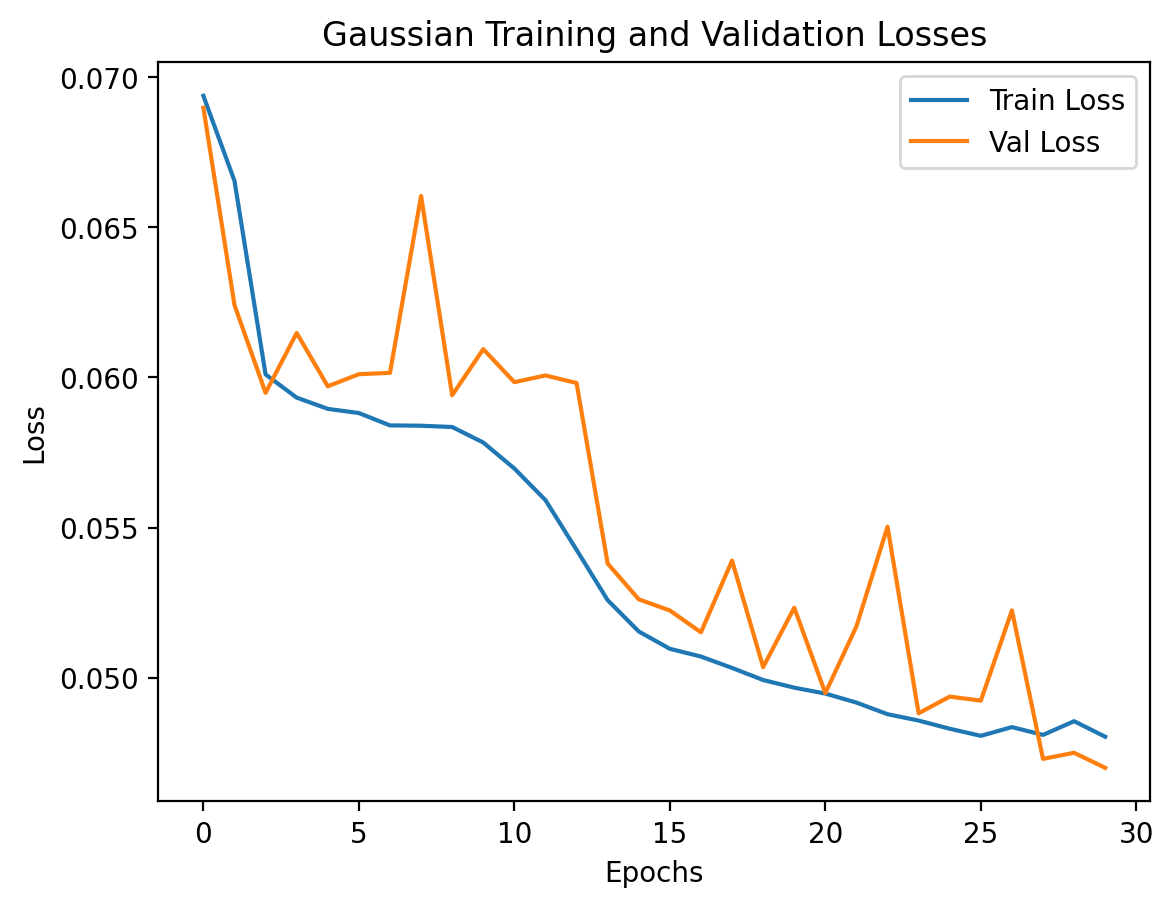

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Gaussian Training and Validation Losses')
plt.legend()
plt.show()

In [ ]:
sp_autoencoder, train_losses, val_losses = train(sp_autoencoder, train_loader, val_loader, noise = "sp", num_epochs = 30)

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SP Training and Validation Losses')
plt.legend()
plt.show()

In [ ]:
speckle_autoencoder, train_losses, val_losses = train(speckle_autoencoder, train_loader, val_loader, noise = "speckle", num_epochs = 30)

Epoch [1/30], Train Loss: 0.0629, Val Loss: 0.0532
Epoch [2/30], Train Loss: 0.0482, Val Loss: 0.0465
Epoch [3/30], Train Loss: 0.0444, Val Loss: 0.0440
Epoch [4/30], Train Loss: 0.0428, Val Loss: 0.0427
Epoch [5/30], Train Loss: 0.0415, Val Loss: 0.0416
Epoch [6/30], Train Loss: 0.0406, Val Loss: 0.0409
Epoch [7/30], Train Loss: 0.0401, Val Loss: 0.0406
Epoch [8/30], Train Loss: 0.0396, Val Loss: 0.0404
Epoch [9/30], Train Loss: 0.0391, Val Loss: 0.0395
Epoch [10/30], Train Loss: 0.0390, Val Loss: 0.0399
Epoch [11/30], Train Loss: 0.0386, Val Loss: 0.0390
Epoch [12/30], Train Loss: 0.0384, Val Loss: 0.0390
Epoch [13/30], Train Loss: 0.0382, Val Loss: 0.0386
Epoch [14/30], Train Loss: 0.0380, Val Loss: 0.0384
Epoch [15/30], Train Loss: 0.0378, Val Loss: 0.0382
Epoch [16/30], Train Loss: 0.0376, Val Loss: 0.0383
Epoch [17/30], Train Loss: 0.0375, Val Loss: 0.0385
Epoch [18/30], Train Loss: 0.0374, Val Loss: 0.0379
Epoch [19/30], Train Loss: 0.0375, Val Loss: 0.0378
Epoch [20/30], Train 

In [12]:
def get_val(model, noise):
    model.eval()
    outputs = []
    noisy = []
    with torch.no_grad():
        for val_inputs, _ in val_loader:
          val_inputs = val_inputs.to(device)
          if noise == "gaussian":
            noisy_inputs = torch.Tensor(add_gaussian_noise(val_inputs.cpu().detach().numpy())).reshape(-1, 28, 28).to(device)
          elif noise == "sp":
            noisy_inputs = torch.Tensor(add_salt_n_pepper_noise(val_inputs.cpu().detach().numpy())).reshape(-1, 28, 28).to(device)
          else:
            noisy_inputs = torch.Tensor(add_speckle_noise(val_inputs.cpu().detach().numpy())).reshape(-1, 28, 28).to(device)

          val_outputs = model(noisy_inputs)
          for noisy_tensor, tensor in zip(noisy_inputs, val_outputs):
            noisy.append(noisy_tensor.reshape((28, 28)).cpu().detach().numpy())
            outputs.append(tensor.reshape((28, 28)).cpu().detach().numpy())
    return noisy, outputs

In [13]:
def show_images(original, noised, reconstructed, n=5):
    fig, axes = plt.subplots(n, 3, figsize=(8, 2 * n))
    for i in range(n):
        # print(noised[i].shape, reconstructed[i].shape)
        axes[i, 0].imshow(original[i])
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(noised[i])
        axes[i, 1].set_title('Noised')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(reconstructed[i])
        axes[i, 2].set_title('Reconstructed')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [14]:
def show_compared_images(model, noise, test_images, n_examples = 5):
  noisy, reconstructed = get_val(model, noise)
  show_images(test_images[:n_examples], noisy[:n_examples], reconstructed[:n_examples], n_examples)

In [ ]:
test_images = val_data.data.numpy()
show_compared_images(gaussian_autoencoder, "gaussian", test_images)
show_compared_images(sp_autoencoder, "sp", test_images)
show_compared_images(speckle_autoencoder, "speckle", test_images)

In [ ]:
latent_dims = 32
input_dim = 28
sp_autoencoder_32 = Autoencoder(latent_dims, input_dim).to(device) # GPU
gaussian_autoencoder_32 = Autoencoder(latent_dims, input_dim).to(device) # GPU
speckle_autoencoder_32 = Autoencoder(latent_dims, input_dim).to(device) # GPU

In [ ]:
gaussian_autoencoder_32, train_losses, val_losses = train(gaussian_autoencoder_32, train_loader, val_loader, noise = "gaussian", num_epochs = 30)

Epoch [1/30], Train Loss: 0.0696, Val Loss: 0.0713
Epoch [2/30], Train Loss: 0.0660, Val Loss: 0.0628
Epoch [3/30], Train Loss: 0.0602, Val Loss: 0.0596
Epoch [4/30], Train Loss: 0.0592, Val Loss: 0.0600
Epoch [5/30], Train Loss: 0.0588, Val Loss: 0.0674
Epoch [6/30], Train Loss: 0.0578, Val Loss: 0.0605
Epoch [7/30], Train Loss: 0.0561, Val Loss: 0.0547
Epoch [8/30], Train Loss: 0.0530, Val Loss: 0.0534
Epoch [9/30], Train Loss: 0.0521, Val Loss: 0.0521
Epoch [10/30], Train Loss: 0.0515, Val Loss: 0.0516
Epoch [11/30], Train Loss: 0.0507, Val Loss: 0.0527
Epoch [12/30], Train Loss: 0.0477, Val Loss: 0.0465
Epoch [13/30], Train Loss: 0.0454, Val Loss: 0.0470
Epoch [14/30], Train Loss: 0.0445, Val Loss: 0.0460
Epoch [15/30], Train Loss: 0.0437, Val Loss: 0.0446
Epoch [16/30], Train Loss: 0.0432, Val Loss: 0.0432
Epoch [17/30], Train Loss: 0.0422, Val Loss: 0.0445
Epoch [18/30], Train Loss: 0.0406, Val Loss: 0.0421
Epoch [19/30], Train Loss: 0.0394, Val Loss: 0.0412
Epoch [20/30], Train 

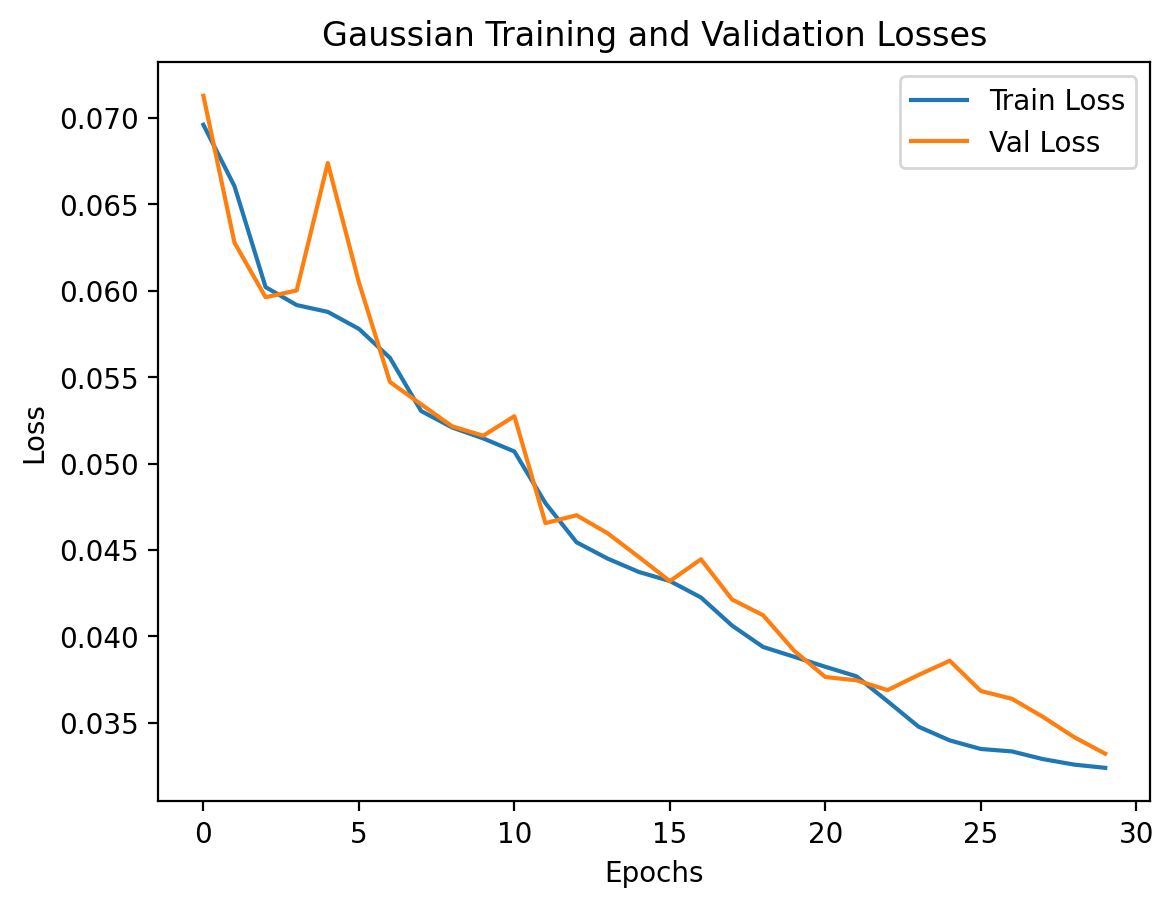

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Gaussian Training and Validation Losses')
plt.legend()
plt.show()

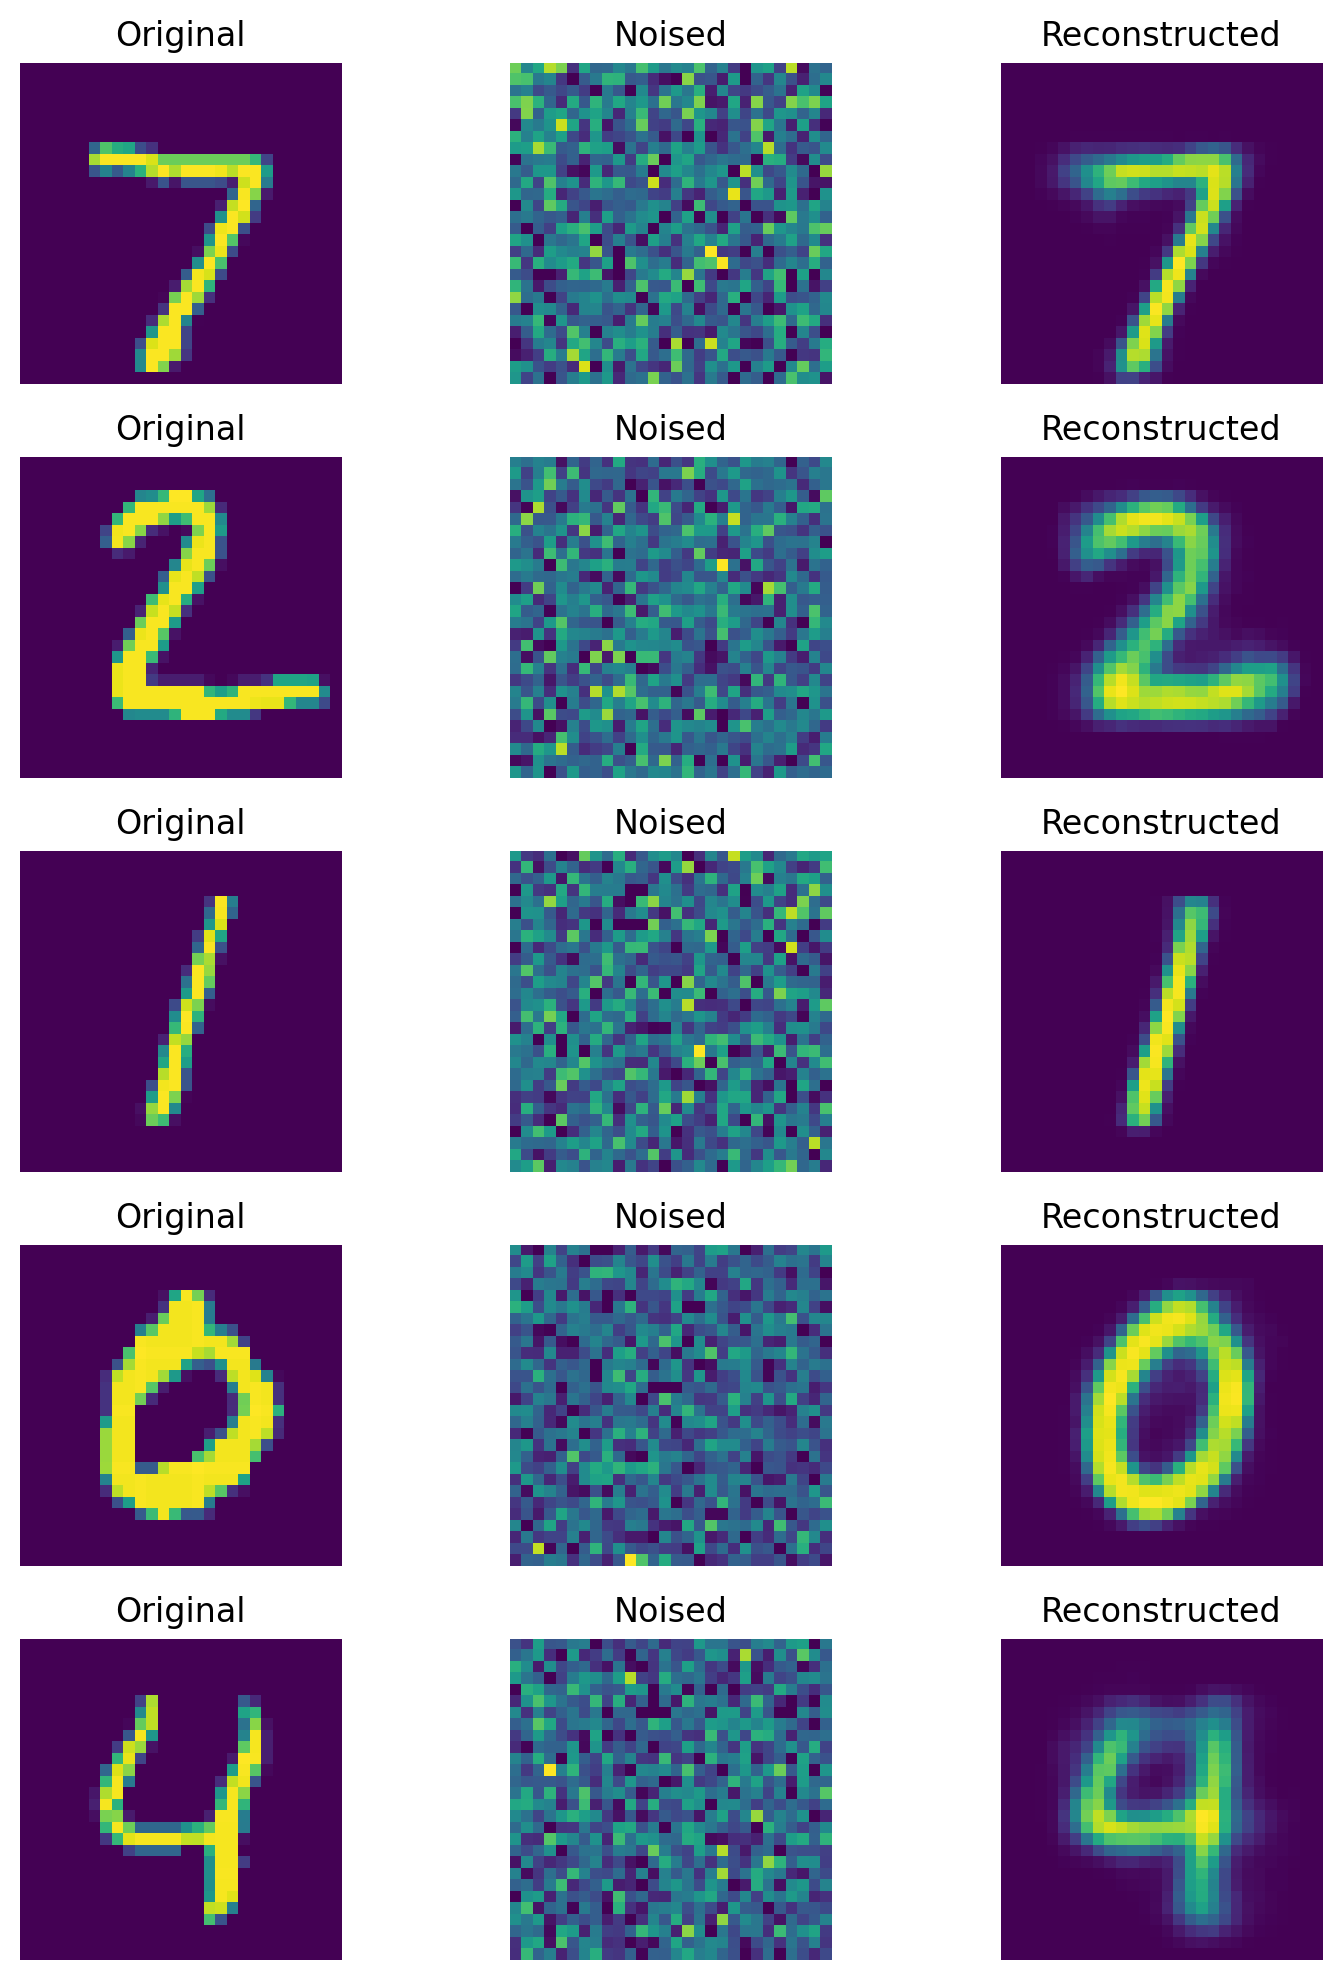

In [ ]:
test_images = val_data.data.numpy()
show_compared_images(gaussian_autoencoder_32, "gaussian", test_images)

In [ ]:
sp_autoencoder_32, train_losses, val_losses = train(sp_autoencoder_32, train_loader, val_loader, noise = "sp", num_epochs = 30)

Epoch [1/30], Train Loss: 0.0592, Val Loss: 0.0417
Epoch [2/30], Train Loss: 0.0345, Val Loss: 0.0314
Epoch [3/30], Train Loss: 0.0277, Val Loss: 0.0266
Epoch [4/30], Train Loss: 0.0226, Val Loss: 0.0219
Epoch [5/30], Train Loss: 0.0201, Val Loss: 0.0202
Epoch [6/30], Train Loss: 0.0188, Val Loss: 0.0189
Epoch [7/30], Train Loss: 0.0177, Val Loss: 0.0182
Epoch [8/30], Train Loss: 0.0167, Val Loss: 0.0167
Epoch [9/30], Train Loss: 0.0158, Val Loss: 0.0161
Epoch [10/30], Train Loss: 0.0150, Val Loss: 0.0152
Epoch [11/30], Train Loss: 0.0143, Val Loss: 0.0145
Epoch [12/30], Train Loss: 0.0136, Val Loss: 0.0141
Epoch [13/30], Train Loss: 0.0132, Val Loss: 0.0134
Epoch [14/30], Train Loss: 0.0127, Val Loss: 0.0134
Epoch [15/30], Train Loss: 0.0124, Val Loss: 0.0127
Epoch [16/30], Train Loss: 0.0120, Val Loss: 0.0126
Epoch [17/30], Train Loss: 0.0117, Val Loss: 0.0123
Epoch [18/30], Train Loss: 0.0115, Val Loss: 0.0126
Epoch [19/30], Train Loss: 0.0112, Val Loss: 0.0120
Epoch [20/30], Train 

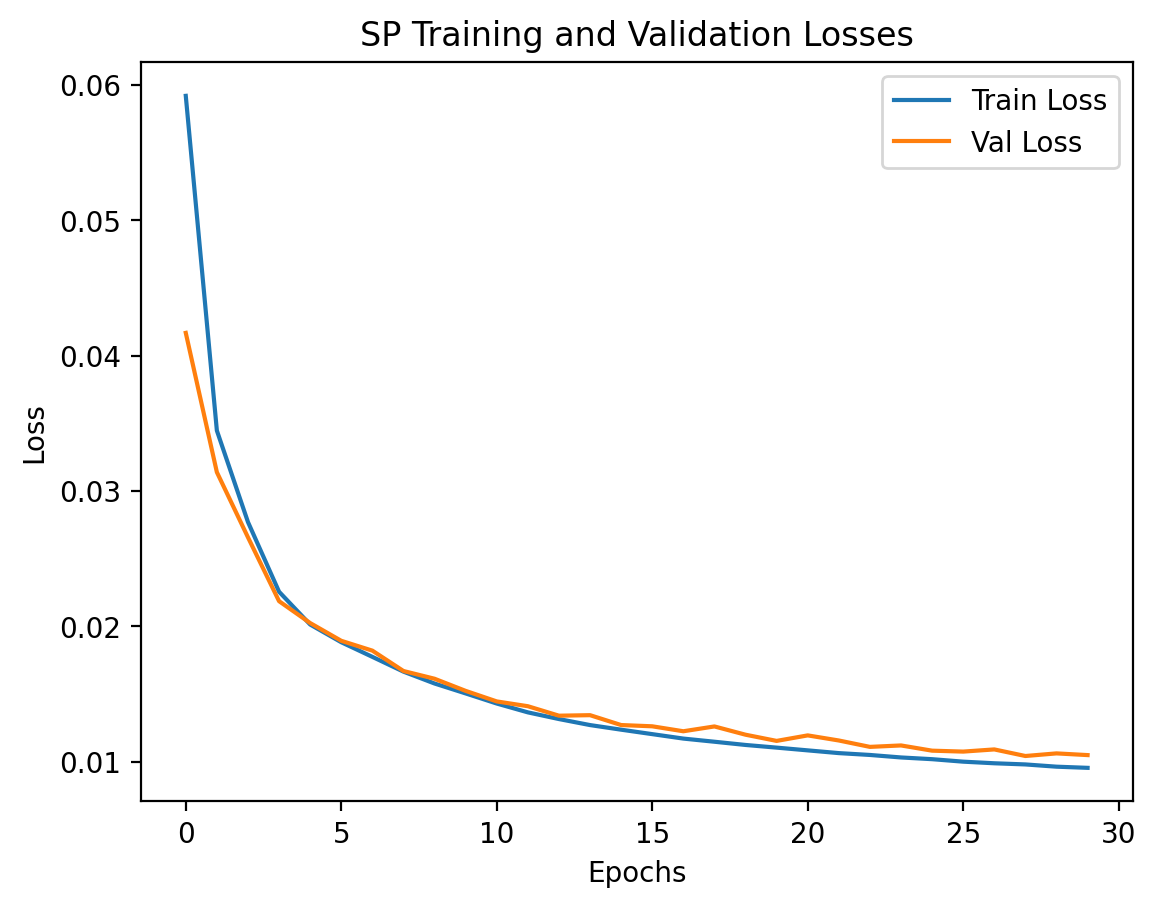

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SP Training and Validation Losses')
plt.legend()
plt.show()

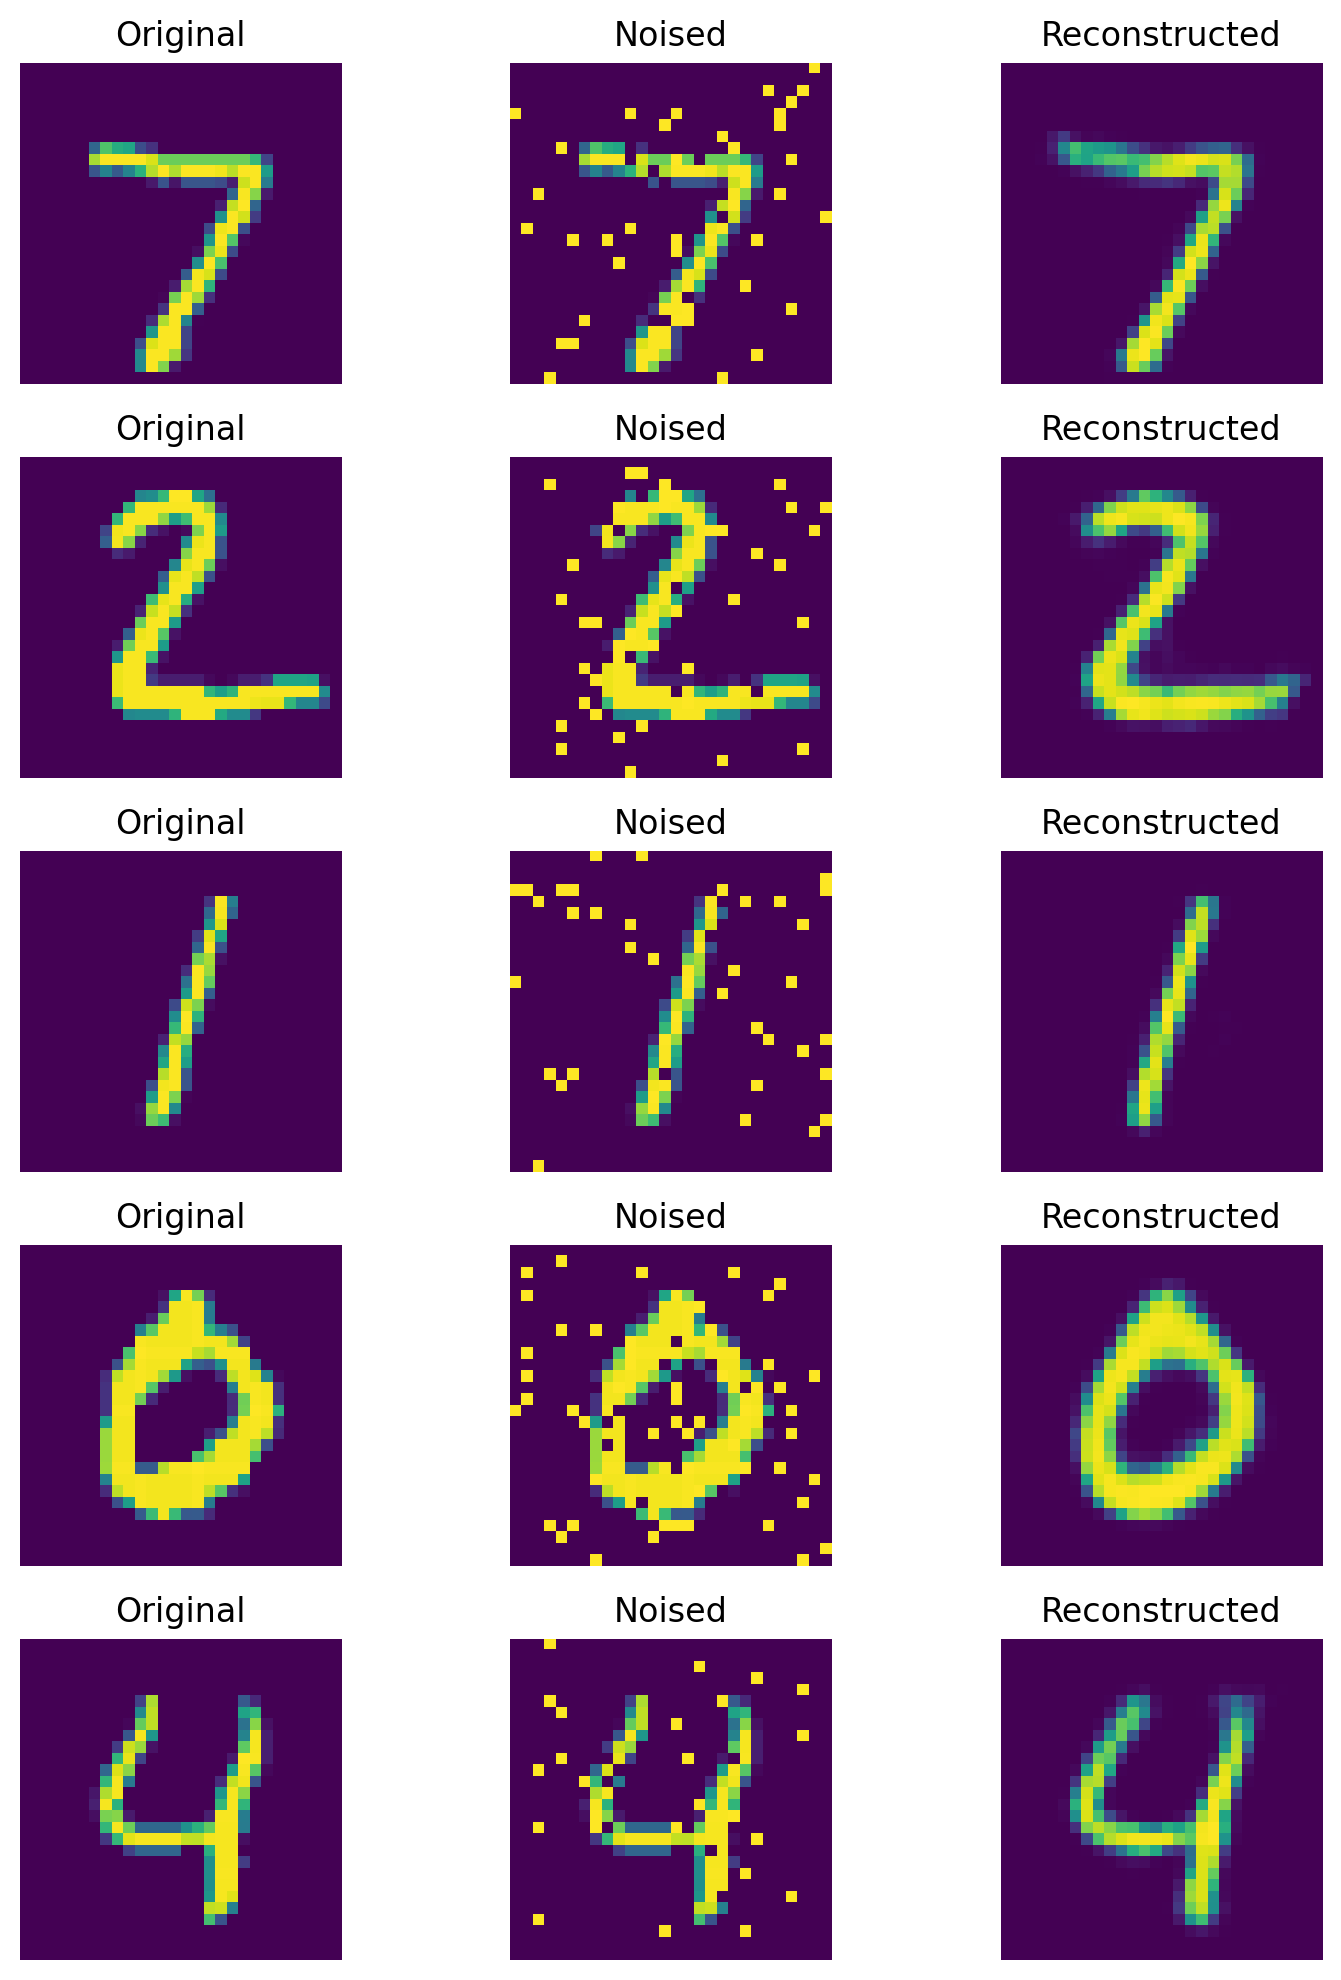

In [ ]:
show_compared_images(sp_autoencoder_32, "sp", test_images)

In [ ]:
speckle_autoencoder_32, train_losses, val_losses = train(speckle_autoencoder_32, train_loader, val_loader, noise = "sp", num_epochs = 30)

Epoch [1/30], Train Loss: 0.0093, Val Loss: 0.0104
Epoch [2/30], Train Loss: 0.0091, Val Loss: 0.0101
Epoch [3/30], Train Loss: 0.0091, Val Loss: 0.0102
Epoch [4/30], Train Loss: 0.0090, Val Loss: 0.0099
Epoch [5/30], Train Loss: 0.0089, Val Loss: 0.0101
Epoch [6/30], Train Loss: 0.0088, Val Loss: 0.0099
Epoch [7/30], Train Loss: 0.0087, Val Loss: 0.0093
Epoch [8/30], Train Loss: 0.0087, Val Loss: 0.0095
Epoch [9/30], Train Loss: 0.0086, Val Loss: 0.0096
Epoch [10/30], Train Loss: 0.0085, Val Loss: 0.0095
Epoch [11/30], Train Loss: 0.0084, Val Loss: 0.0096
Epoch [12/30], Train Loss: 0.0084, Val Loss: 0.0095
Epoch [13/30], Train Loss: 0.0084, Val Loss: 0.0092
Epoch [14/30], Train Loss: 0.0083, Val Loss: 0.0096
Epoch [15/30], Train Loss: 0.0082, Val Loss: 0.0094
Epoch [16/30], Train Loss: 0.0082, Val Loss: 0.0093
Epoch [17/30], Train Loss: 0.0081, Val Loss: 0.0094
Epoch [18/30], Train Loss: 0.0081, Val Loss: 0.0094
Epoch [19/30], Train Loss: 0.0080, Val Loss: 0.0090
Epoch [20/30], Train 

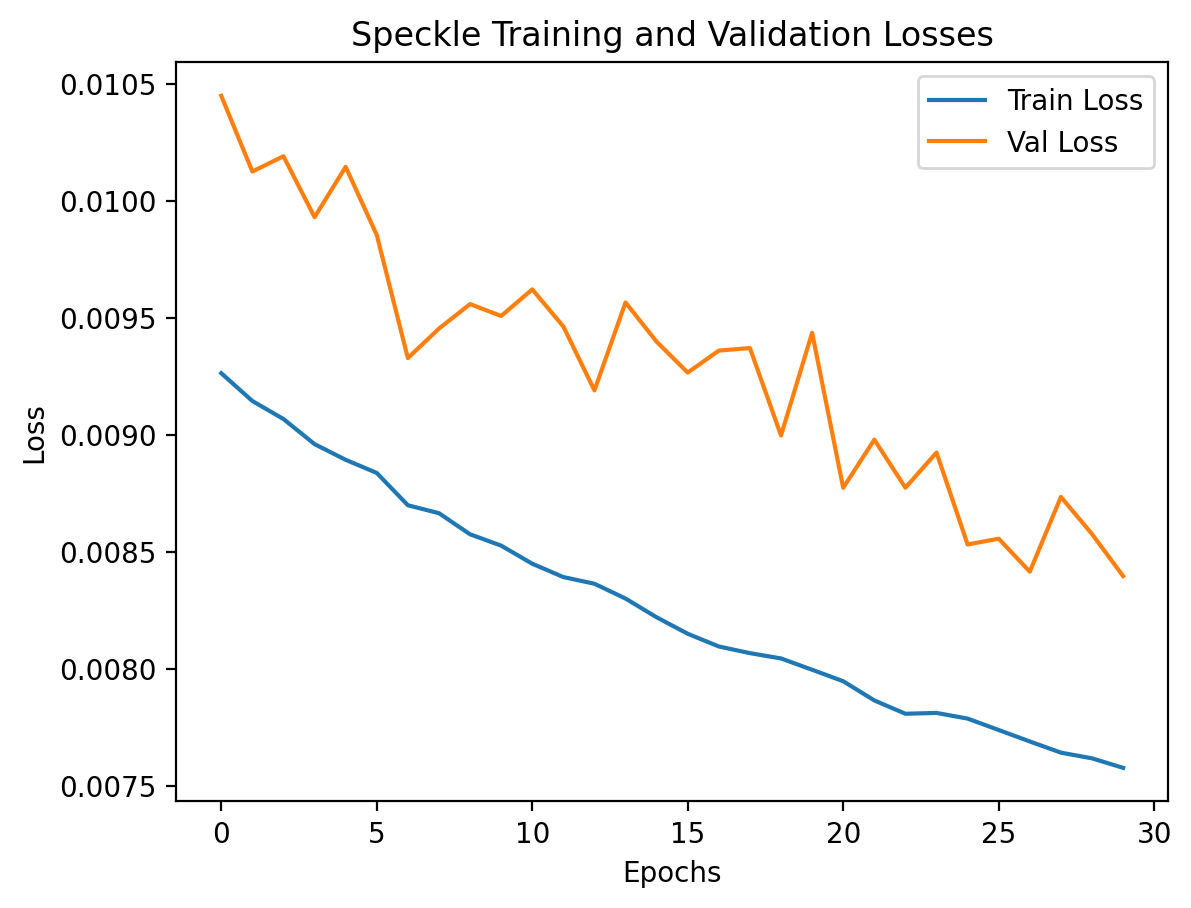

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Speckle Training and Validation Losses')
plt.legend()
plt.show()

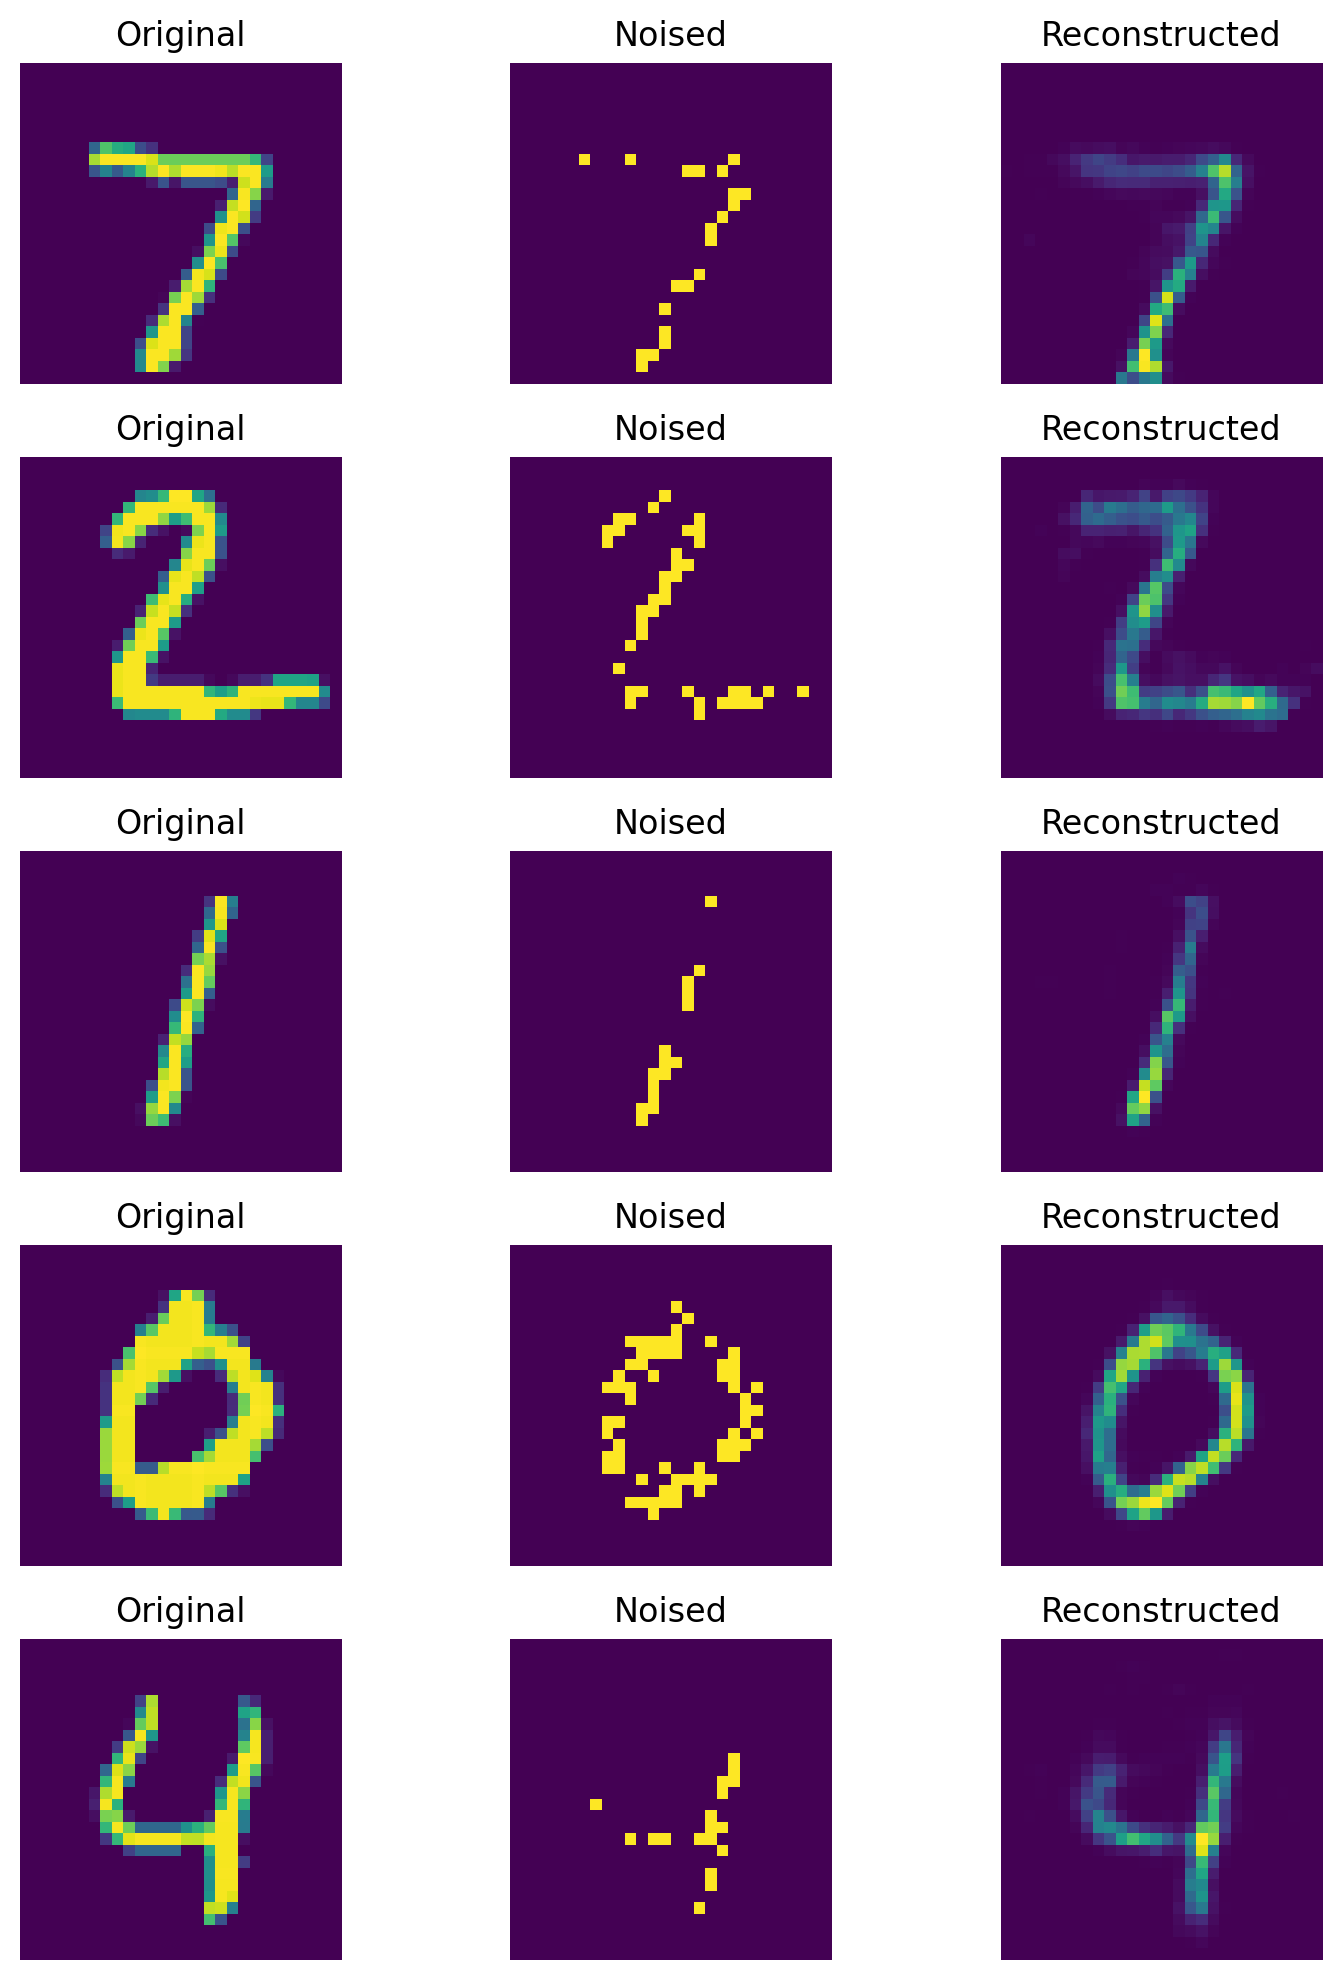

In [ ]:
test_images = val_data.data.numpy()
show_compared_images(spaeckle_autoencoder_32, "speckle", test_images)

In [19]:
from torchvision import datasets, transforms

# Define batch size
batch_size = 128

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load training and validation data
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
val_data = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the Convolutional Denoising Autoencoder
class ConvDenoisingAutoencoder(nn.Module):
    def __init__(self, filter):
        super(ConvDenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(filter, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        # print(x.shape)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiate the model
conv_gaussian_ae = ConvDenoisingAutoencoder(1).to(device)
conv_gaussian_ae, train_losses, val_losses = train(conv_gaussian_ae, train_loader, val_loader, "gaussian", num_epochs = 30)

Epoch [1/30], Train Loss: 0.0811, Val Loss: 0.0724
Epoch [2/30], Train Loss: 0.0689, Val Loss: 0.0660
Epoch [3/30], Train Loss: 0.0638, Val Loss: 0.0626
Epoch [4/30], Train Loss: 0.0600, Val Loss: 0.0646
Epoch [5/30], Train Loss: 0.0571, Val Loss: 0.0553
Epoch [6/30], Train Loss: 0.0556, Val Loss: 0.0531
Epoch [7/30], Train Loss: 0.0532, Val Loss: 0.0533
Epoch [8/30], Train Loss: 0.0523, Val Loss: 0.0497
Epoch [9/30], Train Loss: 0.0506, Val Loss: 0.0486
Epoch [10/30], Train Loss: 0.0500, Val Loss: 0.0516
Epoch [11/30], Train Loss: 0.0498, Val Loss: 0.0517
Epoch [12/30], Train Loss: 0.0479, Val Loss: 0.0690
Epoch [13/30], Train Loss: 0.0481, Val Loss: 0.0462
Epoch [14/30], Train Loss: 0.0466, Val Loss: 0.0466
Epoch [15/30], Train Loss: 0.0461, Val Loss: 0.0456
Epoch [16/30], Train Loss: 0.0471, Val Loss: 0.0448
Epoch [17/30], Train Loss: 0.0463, Val Loss: 0.0440
Epoch [18/30], Train Loss: 0.0460, Val Loss: 0.0460
Epoch [19/30], Train Loss: 0.0444, Val Loss: 0.0435
Epoch [20/30], Train 

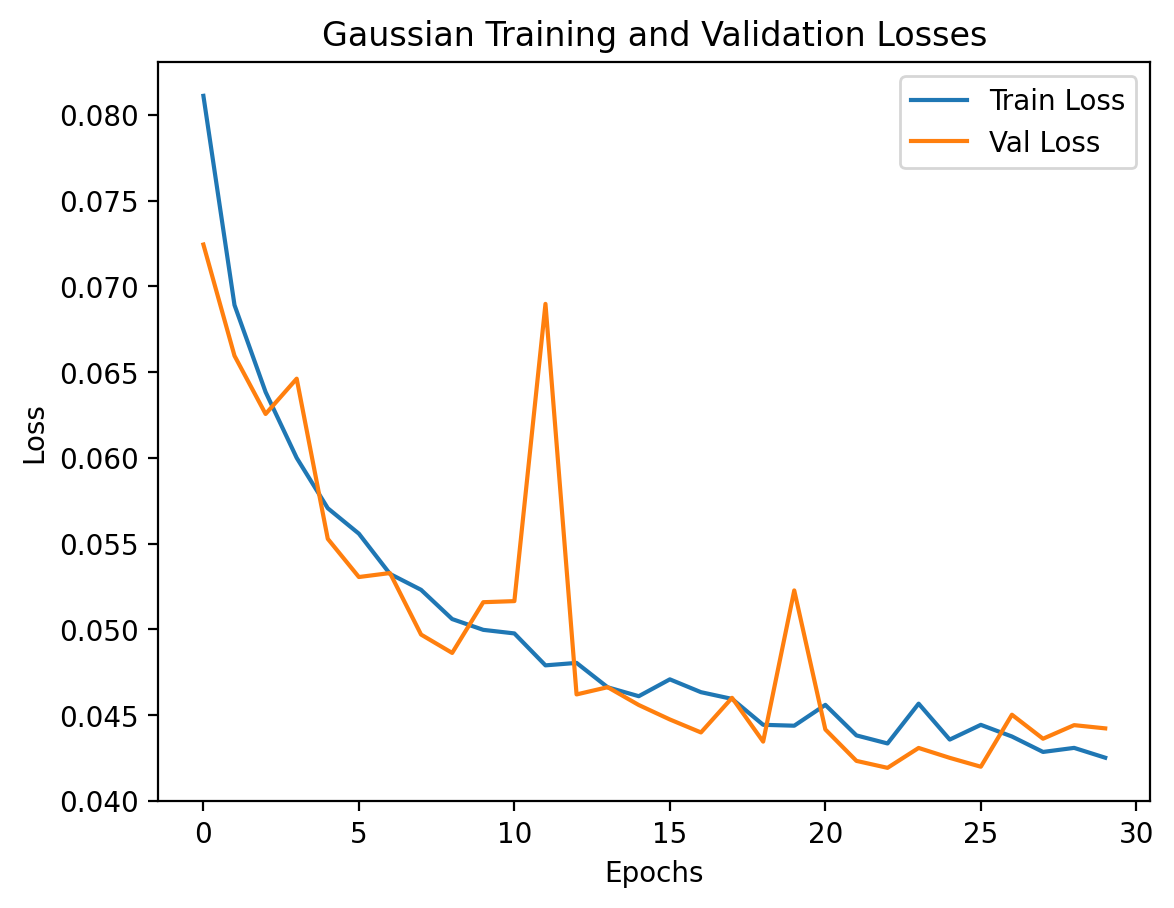

In [30]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Gaussian Training and Validation Losses')
plt.legend()
plt.show()

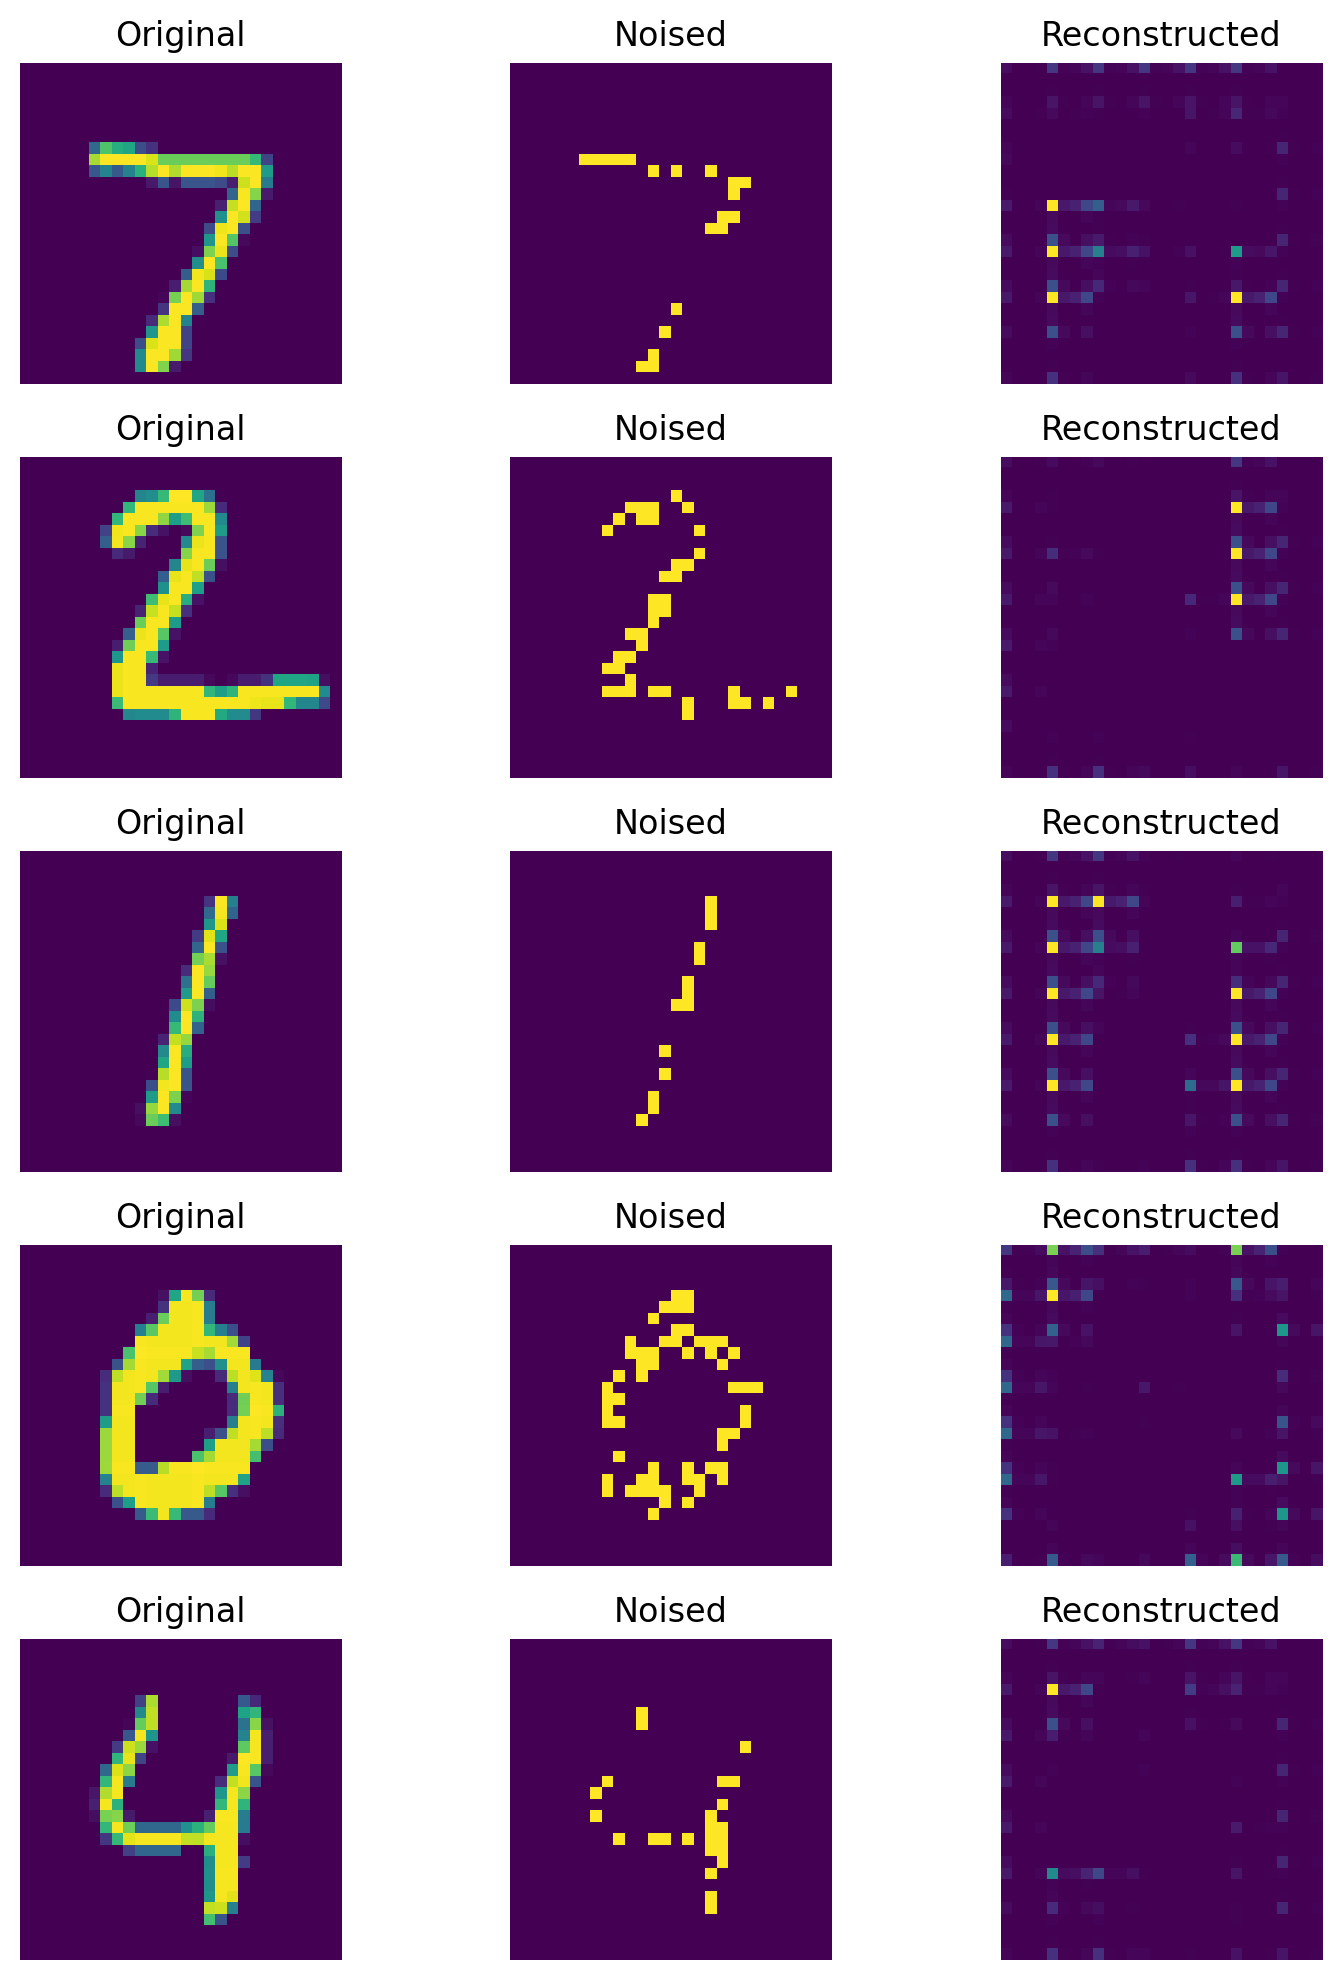

In [36]:
test_images = val_data.data.numpy()
show_compared_images(conv_gaussian_ae, "speckle", test_images)

In [32]:
conv_sp_ae = ConvDenoisingAutoencoder(1).to(device)
conv_sp_ae, train_losses, val_losses = train(conv_sp_ae, train_loader, val_loader, "sp", num_epochs = 30)

Epoch [1/30], Train Loss: 0.0348, Val Loss: 0.0076
Epoch [2/30], Train Loss: 0.0069, Val Loss: 0.0062
Epoch [3/30], Train Loss: 0.0060, Val Loss: 0.0056
Epoch [4/30], Train Loss: 0.0055, Val Loss: 0.0052
Epoch [5/30], Train Loss: 0.0051, Val Loss: 0.0049
Epoch [6/30], Train Loss: 0.0049, Val Loss: 0.0047
Epoch [7/30], Train Loss: 0.0047, Val Loss: 0.0045
Epoch [8/30], Train Loss: 0.0045, Val Loss: 0.0043
Epoch [9/30], Train Loss: 0.0044, Val Loss: 0.0042
Epoch [10/30], Train Loss: 0.0042, Val Loss: 0.0041
Epoch [11/30], Train Loss: 0.0041, Val Loss: 0.0040
Epoch [12/30], Train Loss: 0.0040, Val Loss: 0.0039
Epoch [13/30], Train Loss: 0.0039, Val Loss: 0.0038
Epoch [14/30], Train Loss: 0.0038, Val Loss: 0.0037
Epoch [15/30], Train Loss: 0.0038, Val Loss: 0.0037
Epoch [16/30], Train Loss: 0.0037, Val Loss: 0.0036
Epoch [17/30], Train Loss: 0.0037, Val Loss: 0.0036
Epoch [18/30], Train Loss: 0.0036, Val Loss: 0.0035
Epoch [19/30], Train Loss: 0.0036, Val Loss: 0.0035
Epoch [20/30], Train 

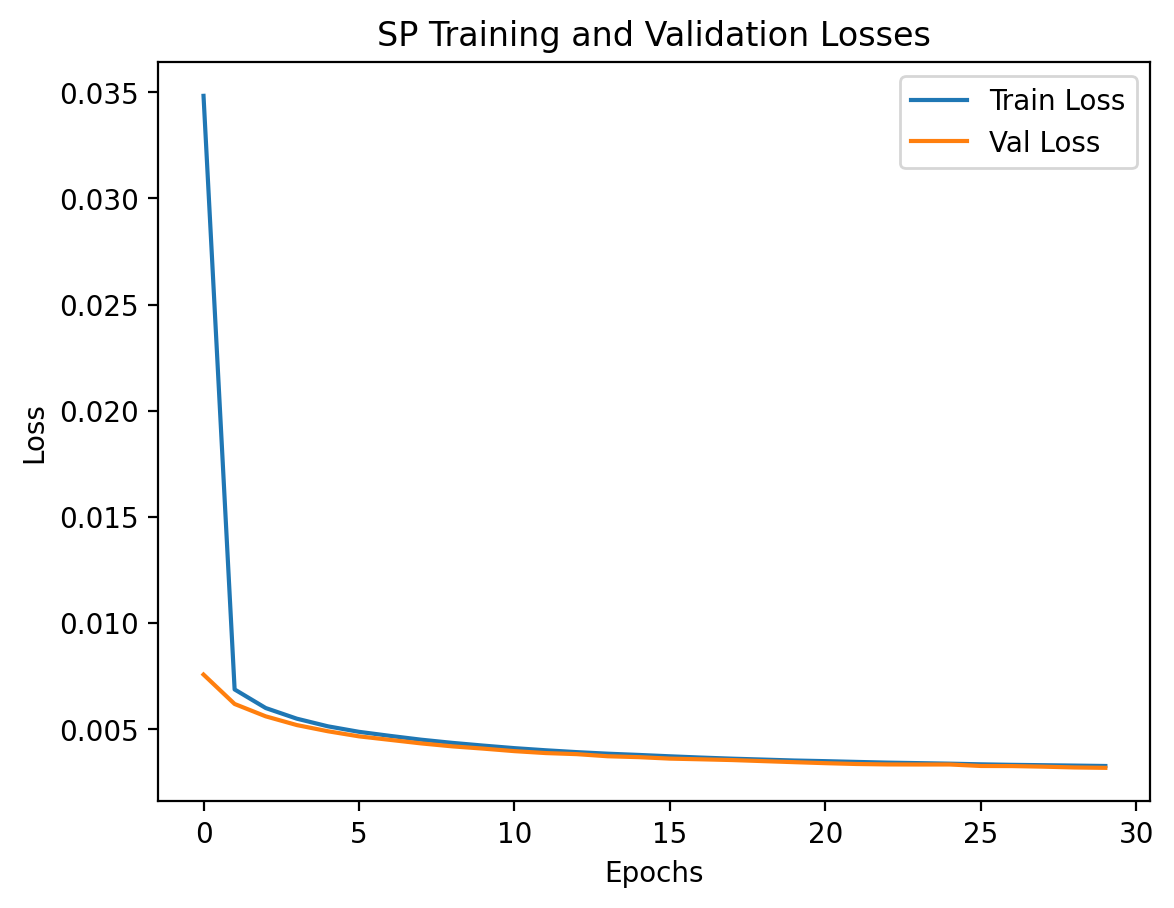

In [33]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SP Training and Validation Losses')
plt.legend()
plt.show()

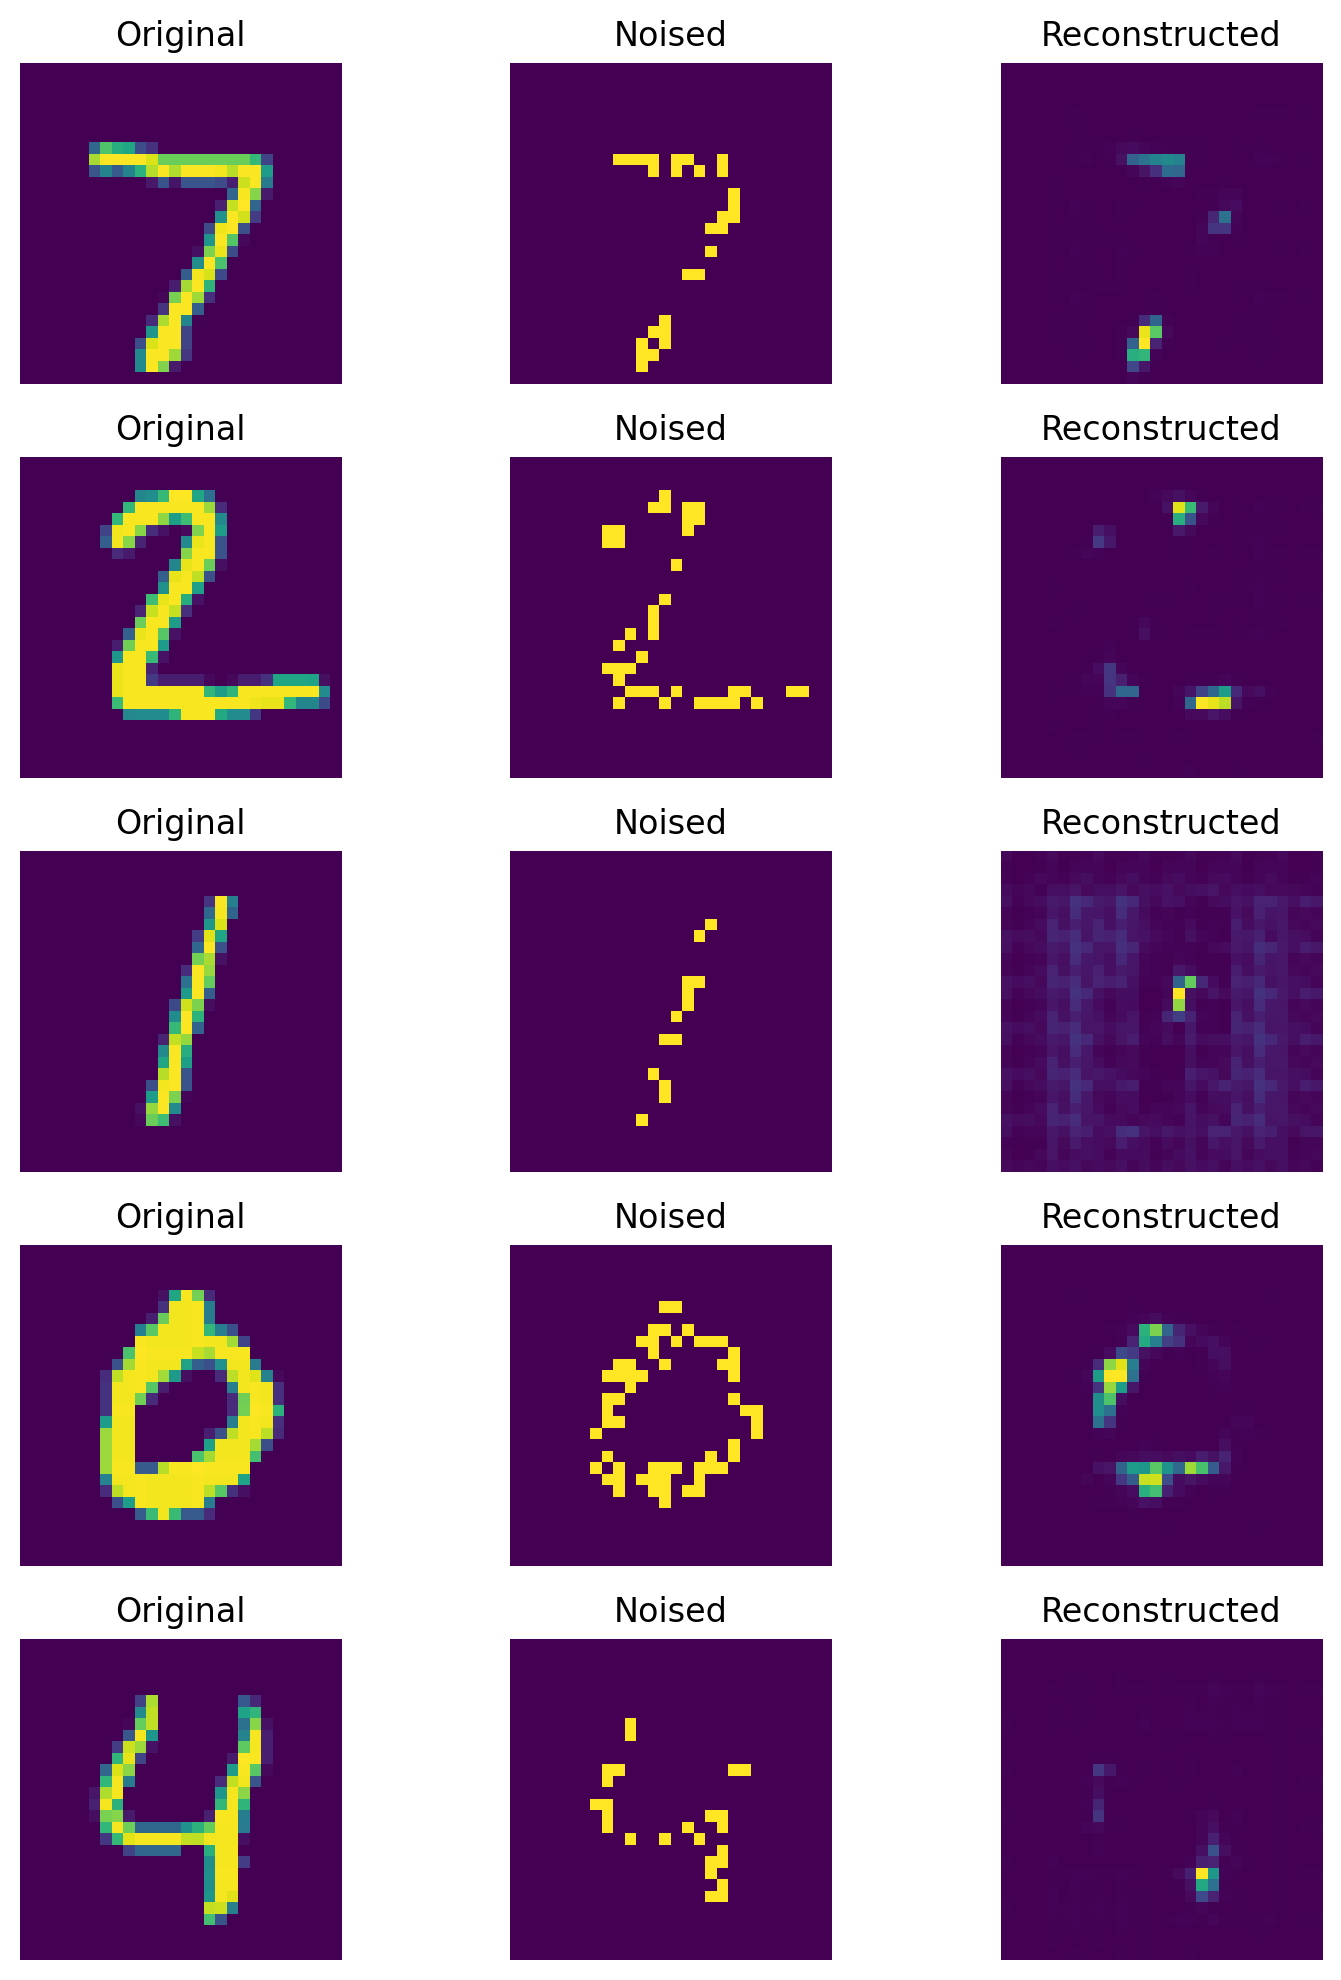

In [38]:
test_images = val_data.data.numpy()
show_compared_images(conv_sp_ae, "speckle", test_images)

In [34]:
conv_speckle_ae = ConvDenoisingAutoencoder(1).to(device)
conv_speckle_ae, train_losses, val_losses = train(conv_speckle_ae, train_loader, val_loader, "speckle", num_epochs = 30)

Epoch [1/30], Train Loss: 0.0301, Val Loss: 0.0166
Epoch [2/30], Train Loss: 0.0161, Val Loss: 0.0156
Epoch [3/30], Train Loss: 0.0155, Val Loss: 0.0151
Epoch [4/30], Train Loss: 0.0151, Val Loss: 0.0148
Epoch [5/30], Train Loss: 0.0149, Val Loss: 0.0146
Epoch [6/30], Train Loss: 0.0148, Val Loss: 0.0145
Epoch [7/30], Train Loss: 0.0147, Val Loss: 0.0144
Epoch [8/30], Train Loss: 0.0146, Val Loss: 0.0145
Epoch [9/30], Train Loss: 0.0145, Val Loss: 0.0142
Epoch [10/30], Train Loss: 0.0144, Val Loss: 0.0142
Epoch [11/30], Train Loss: 0.0144, Val Loss: 0.0142
Epoch [12/30], Train Loss: 0.0143, Val Loss: 0.0141
Epoch [13/30], Train Loss: 0.0143, Val Loss: 0.0142
Epoch [14/30], Train Loss: 0.0143, Val Loss: 0.0140
Epoch [15/30], Train Loss: 0.0142, Val Loss: 0.0141
Epoch [16/30], Train Loss: 0.0142, Val Loss: 0.0140
Epoch [17/30], Train Loss: 0.0141, Val Loss: 0.0140
Epoch [18/30], Train Loss: 0.0141, Val Loss: 0.0140
Epoch [19/30], Train Loss: 0.0141, Val Loss: 0.0138
Epoch [20/30], Train 

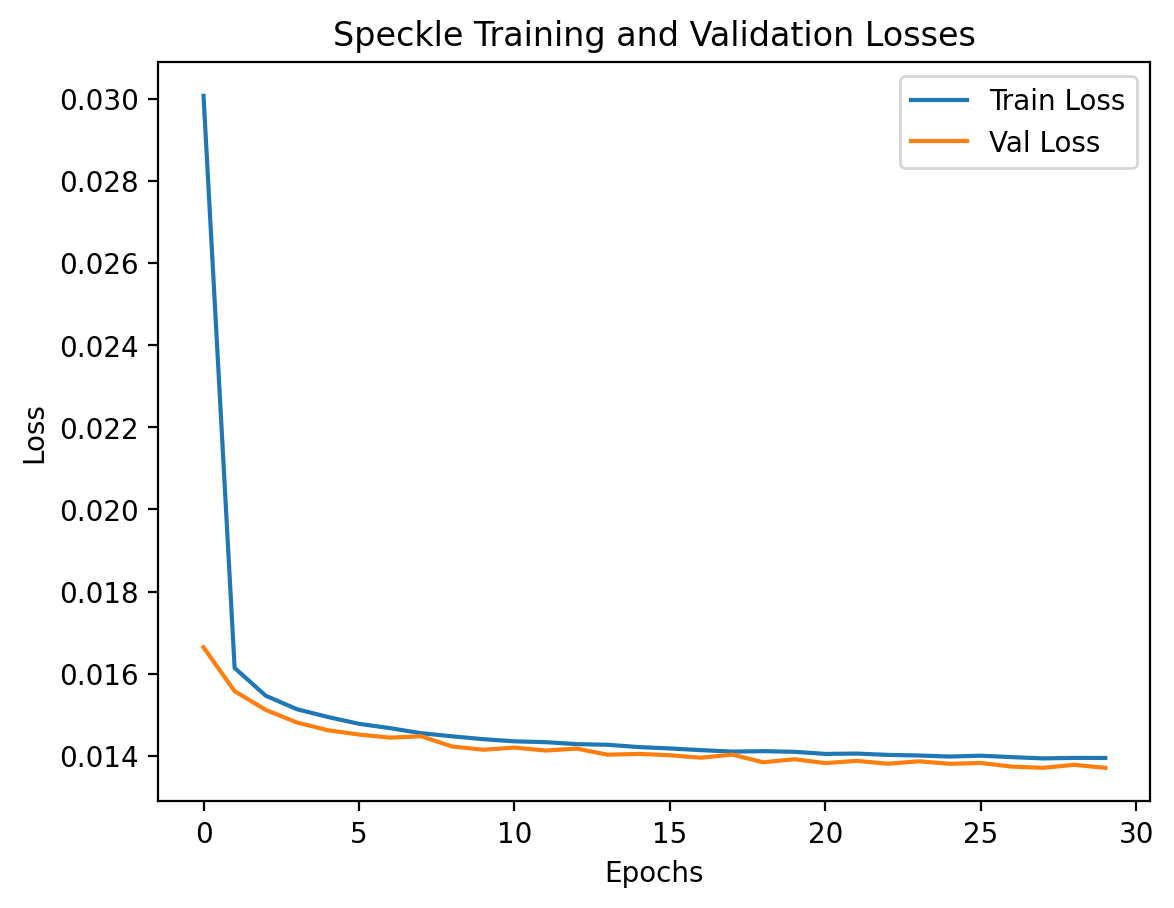

In [35]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Speckle Training and Validation Losses')
plt.legend()
plt.show()

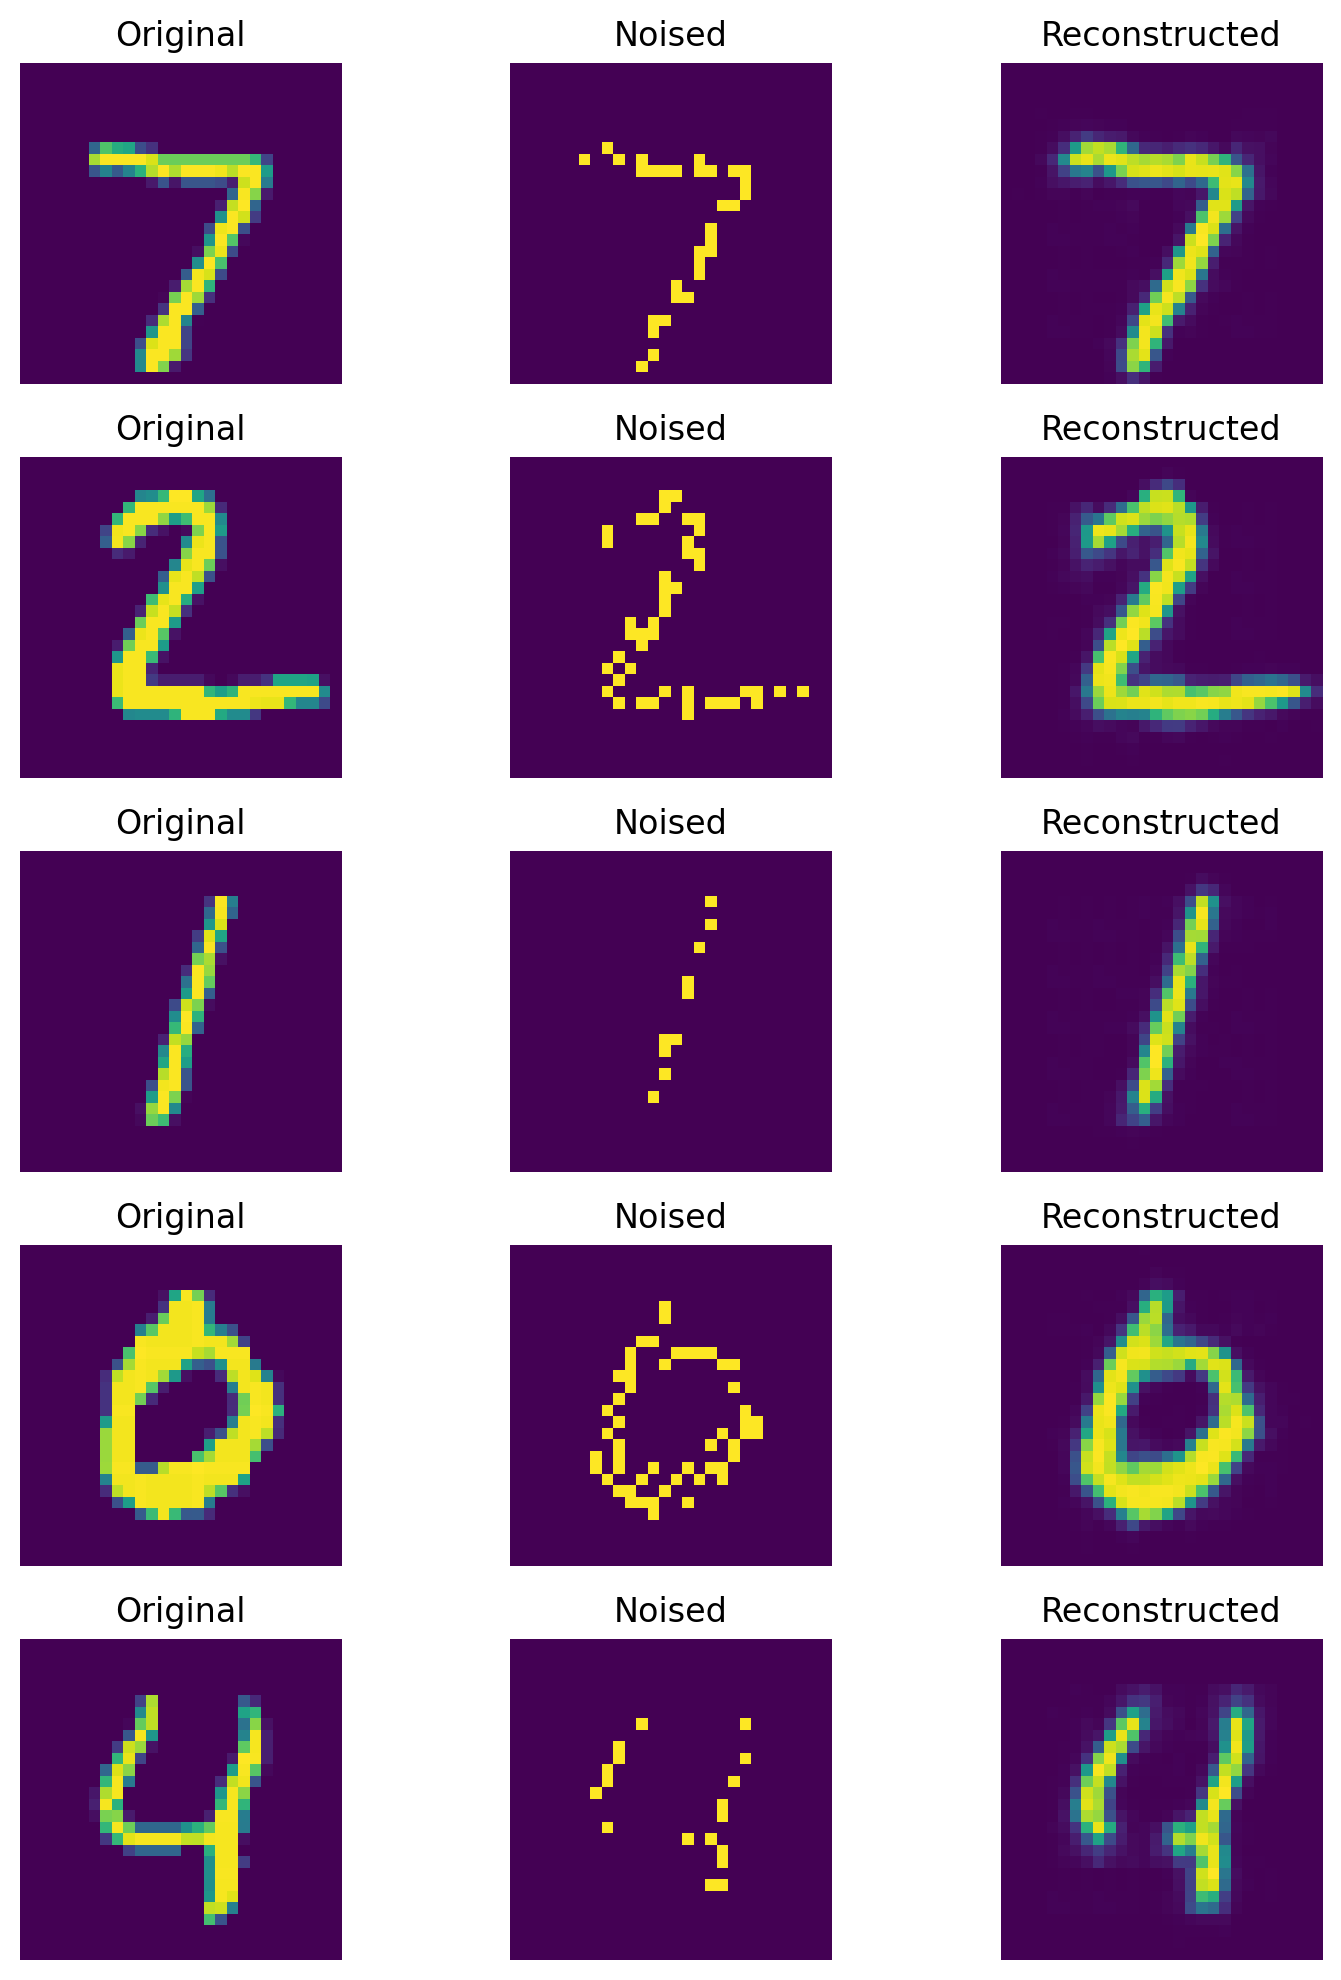

In [37]:
test_images = val_data.data.numpy()
show_compared_images(conv_speckle_ae, "speckle", test_images)

***

> **Question 2**: Test an overcomplete, linear AE, and plot training and test loss. Compare it to the losses of the undercomplete version.

### SOLUTION

***

 What should we look at once we've trained an autoencoder?

1. Look at the latent space. If the latent space is 2-dimensional, then we can transform a batch of inputs $x$ using the encoder and make a scatterplot of the output vectors. Since we also have access to labels for MNIST, we can colour code the outputs to see what they look like.
2. Sample the latent space to produce output. If the latent space is 2-dimensional, we can sample latent vectors $z$ from the latent space over a uniform grid and plot the decoded latent vectors on a grid.

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
       # print(x.shape)
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10',s=1)
        if i > num_batches:
            plt.colorbar()
            break

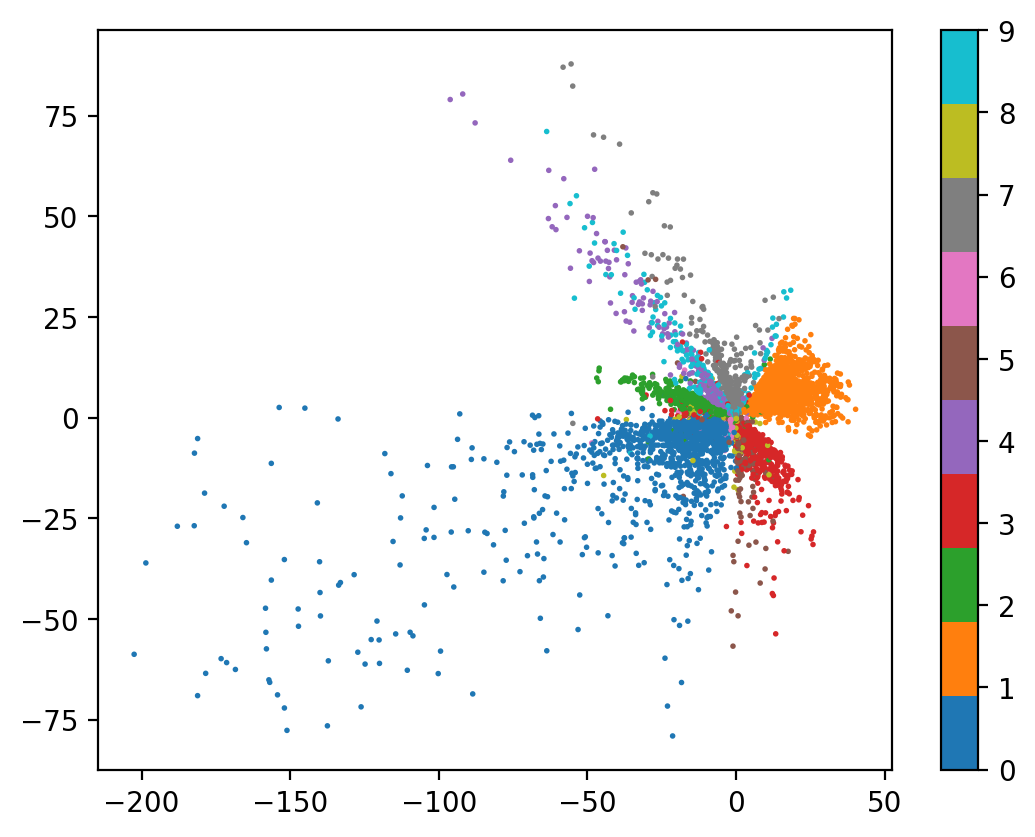

In [ ]:
plot_latent(speckle_autoencoder, train_loader, num_batches=100)

The resulting latent vectors cluster similar digits together. We can also sample uniformly from the latent space and see how the decoder reconstructs inputs from arbitrary latent vectors.

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 30), r1=(-20, 15), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

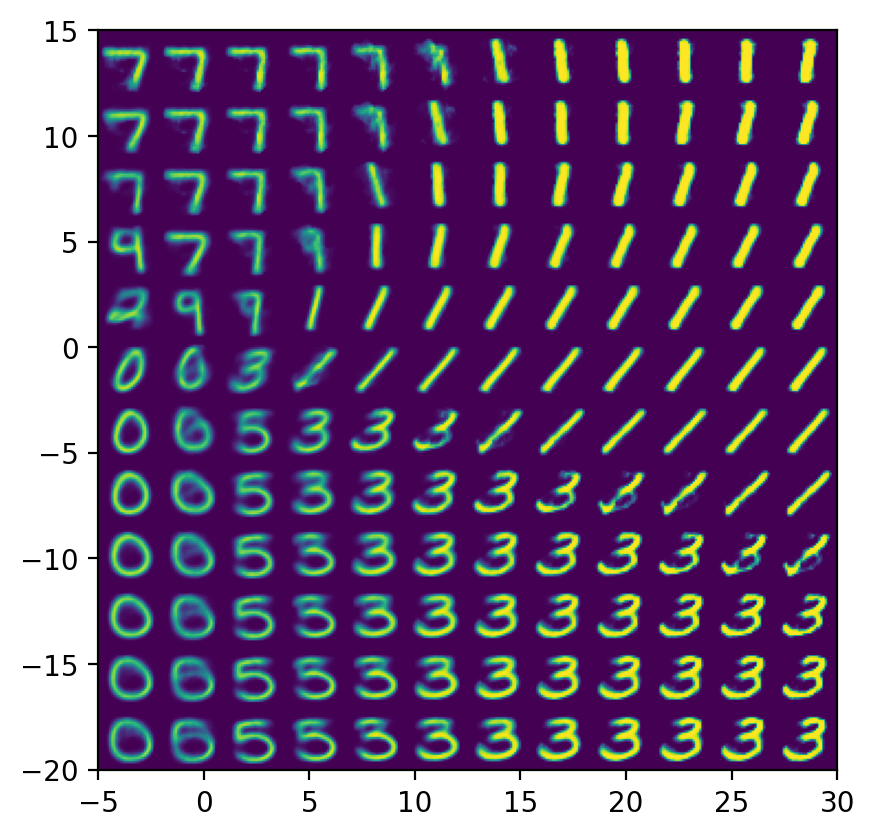

In [ ]:
plot_reconstructed(speckle_autoencoder)

We intentionally plot the reconstructed latent vectors using approximately the same range of values taken on by the actual latent vectors. We can see that the reconstructed latent vectors look like digits, and the kind of digit corresponds to the location of the latent vector in the latent space.

You may have noticed that there are "gaps" in the latent space, where data is never mapped to. This becomes a problem when we try to use autoencoders as **generative models**. The goal of generative models is to take a data set $X$ and produce more data points from the same distribution that $X$ is drawn from. For autoencoders, this means sampling latent vectors $z \sim Z$ and then decoding the latent vectors to produce images. If we sample a latent vector from a region in the latent space that was never seen by the decoder during training, the output might not make any sense at all. We see this in the top left corner of the `plot_reconstructed` output, which is empty in the latent space, and the corresponding decoded digit does not match any existing digits.

The following code produces a row of images showing the interpolation between digits.

In [ ]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
x, y = next(data.__iter__()) # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

In [ ]:
interpolate(vae, x_1, x_2, n=20)

In [ ]:
interpolate(autoencoder, x_1, x_2, n=20)

## 6 - Exercises

We start by noising the training and testing images with gaussian noise

2. implement a DAE; you can use different numbers of layers / activation functions / dimension of latent space

In [ ]:
!pip install pytorch-lightning --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
class DenoisingAutoencoder(pl.LightningModule):
  def __init__(self, input_dim=784, hidden_dim=256, latent_dim=64):
    super(DenoisingAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 128),
        nn.ReLU(),
        # nn.Linear(128, 128),
        # nn.ReLU(),
        nn.Linear(128, latent_dim)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 128),
        nn.ReLU(),
        # nn.Linear(128, 128),
        # nn.ReLU(),
        nn.Linear(128, input_dim),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.encoder(x)
    x = self.decoder(x)
    return x

  def initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Linear):
              nn.init.xavier_uniform_(m.weight)
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0.0)

  def training_step(self, batch, batch_idx):
    x_noisy, x_clean = batch
    # fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    # axes[0].imshow(x_noisy[0].cpu(), cmap='gray')
    # axes[0].axis('off')
    # axes[1].imshow(x_clean[0].cpu(), cmap='gray')
    # axes[1].axis('off')
    recon = self.forward(x_noisy)
    loss = nn.MSELoss()(recon, x_clean.view(x_clean.size(0), -1))
    self.log("train_loss", loss)
    return loss

  def validation_step(self, batch, batch_idx):
    x_noisy, x_clean = batch
    recon = self.forward(x_noisy)
    loss = nn.MSELoss()(recon, x_clean.view(x_clean.size(0), -1))
    self.log("val_loss", loss, prog_bar=True)
    return loss

  def configure_optimizers(self):
    return optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
class NoisedDataModule(pl.LightningDataModule):
    def __init__(self, train_noised, train_clean, val_noised, val_clean, batch_size=64):
        super().__init__()
        self.train_noised = train_noised
        self.train_clean = train_clean
        self.val_noised = val_noised
        self.val_clean = val_clean
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = torch.utils.data.TensorDataset(
            torch.tensor(self.train_noised, dtype=torch.float32),
            torch.tensor(self.train_clean, dtype=torch.float32)
        )

        self.val_dataset = torch.utils.data.TensorDataset(
            torch.tensor(self.val_noised, dtype=torch.float32),
            torch.tensor(self.val_clean, dtype=torch.float32)
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size)


4. compare different types (gaussian / salt n pepper) and levels of noise on the performance of the DAE

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
train_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=train_transforms)
val_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
def create_noise_dataset(train_images, test_images, gaussian_noise=True):
    noised_train = np.zeros((len(train_images), 28, 28), dtype='float32')
    for i in range(len(train_images)):
        if gaussian_noise:
            noised_train[i] = np.float32(add_gaussian_noise(train_images[i])).reshape(28, 28)
        else:
            noised_train[i] = np.float32(add_salt_n_pepper_noise(train_images[i])).reshape(28, 28)

    noised_test = np.zeros((len(test_images), 28, 28), dtype='float32')
    for i in range(len(test_images)):
        if gaussian_noise:
            noised_test[i] = np.float32(add_gaussian_noise(test_images[i])).reshape(28, 28)
        else:
            noised_test[i] = np.float32(add_salt_n_pepper_noise(test_images[i])).reshape(28, 28)

    return noised_train, noised_test

noised_train_gaussian, noised_val_gaussian = create_noise_dataset(train_data.data.numpy(), val_data.data.numpy(), gaussian_noise=True)
noised_train_sp, noised_val_sp = create_noise_dataset(train_data.data.numpy(), val_data.data.numpy(), gaussian_noise=False)

In [ ]:
train_images = train_data.data.numpy().reshape(-1, 28*28)

In [ ]:
input_dim = 28 * 28
latent_dim = 64
dae_gaussian = DenoisingAutoencoder(input_dim, latent_dim)
dae_sp = DenoisingAutoencoder(input_dim, latent_dim)

batch_size = 64
dm_gaussian = NoisedDataModule(train_noised=train_data.data.numpy(), train_clean=train_data.data.numpy(),
                               val_noised=val_data.data.numpy(), val_clean=val_data.data.numpy(),
                               batch_size=64)

dm_sp = NoisedDataModule(train_noised=noised_train_sp, train_clean=train_data.data.numpy(),
                               val_noised=noised_val_sp, val_clean=val_data.data.numpy(),
                               batch_size=64)

In [ ]:
early_stopping_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    min_delta=0.001,      # minimum change in the monitored quantity to qualify as improvement
    patience=5,           # number of epochs with no improvement after which training will be stopped
    verbose=True          # print information about early stopping
)

trainer_gaussian = pl.Trainer(max_epochs=50, accelerator="auto", callbacks=[early_stopping_callback])
trainer_gaussian.fit(dae_gaussian, dm_gaussian)

# trainer_sp = pl.Trainer(max_epochs=50, callbacks=[early_stopping_callback])
# trainer_sp.fit(dae_sp, dm_sp)

In [ ]:
plt.plot(trainer_gaussian.callback_metrics['train_loss'].cpu(), label='Train Loss')
plt.plot(trainer_gaussian.callback_metrics['val_loss'].cpu(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [ ]:
reconstructed_gaussian_test = dae_gaussian.decoder(dae_gaussian.encoder(torch.tensor(noised_val_gaussian).view(-1, 28*28))).detach().numpy()
reconstructed_sp_test = dae_sp.decoder(dae_sp.encoder(torch.tensor(noised_val_sp).view(-1, 28*28))).detach().numpy()

In [ ]:
reconstructed_gaussian_test = reconstructed_gaussian_test.reshape((-1, 28, 28))
num_examples, height_width = reconstructed_sp_test.shape[0], reconstructed_sp_test.shape[1]
reconstructed_sp_images = reconstructed_sp_test.reshape(num_examples, 28, 28)
reconstructed_gaussian_test = reconstructed_gaussian_test.reshape(num_examples, 28, 28)
noised_val_gaussian_img = noised_val_gaussian.reshape(num_examples, 28, 28)


5. compare different DAE architectures regarding the denoising performances.

3. Make a plot with the original image, the noised image and the reconstructed image for several examples of input images.

In [ ]:
def show_images(original, noised, reconstructed, n=5):
    fig, axes = plt.subplots(n, 3, figsize=(8, 2 * n))
    for i in range(n):
        # print(noised[i].shape, reconstructed[i].shape)
        axes[i, 0].imshow(original[i], cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(noised[i], cmap='gray')
        axes[i, 1].set_title('Noised')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(reconstructed[i], cmap='gray')
        axes[i, 2].set_title('Reconstructed')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
n_examples = 5
test_images = val_data.data.numpy()
show_images(test_images[:n_examples], noised_val_gaussian_img[:n_examples], reconstructed_gaussian_test[:n_examples])
# show_images(test_images[:n_examples], noised_val_sp[:n_examples], reconstructed_sp_test[:n_examples])